In [8]:
# add tools and modules contained within tools (numpy, scipy, pandas, blabla)
import sys
sys.path.insert(0, "../../library")
from bikbox import *
from LIDAR import *

from collections import namedtuple

from os import path

from scipy.stats import linregress

# configure matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn

from windrose import WindroseAxes

from bokeh.io import output_notebook, show
from bokeh.plotting import figure

from mpl_toolkits.mplot3d import Axes3D

from math import sqrt
from math import log

from scipy.signal import find_peaks

from glob import glob

import io       # used to generate a string buffer

from zipfile import ZipFile

# enable auto reloading of external modules
%reload_ext autoreload
%autoreload 2

# %matplotlib ipympl
# %matplotlib widget
%matplotlib notebook
# %matplotlib inline

sen_green = '#1f986d'

single_column_size = (3.22, 3.22)
double_column_size = (6.44, 3.22)

# matplotlib config

mpl.rcParams['figure.figsize'] = [7.0, 6.0]
#mpl.rcParams['figure.dpi'] = 15
mpl.rcParams['savefig.dpi'] = 150

mpl.rcParams['font.size'] = 12
#mpl.rcParams['legend.fontsize'] = 'large'
#mpl.rcParams['figure.titlesize'] = 'medium'

#axes.spines.left   : True   ## display axis spines
#axes.spines.bottom : True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
#ax.spines['right'].set_color('none')
#ax.spines['top'].set_color('none')

plt.style.use('seaborn-ticks')
plt.rc("axes.spines", top=False, right=False)

cmap = plt.get_cmap('jet', 14)

def cc(n=14):
    return iter(cm.viridis(np.linspace(0,1,14)))

labelmap = dict()

linCorr = namedtuple('linCorr', 'slope intercept r_value p_value std_err')

i = 1

for bwdir in sorted(glob('../../../data/BW??')):
    bw = bwdir.split('/')[-1]
    # if bw in ('BW74', 'BW76',): continue
    fused_file = '{}/{}_fused_EuroDyn20.pickle'.format(bwdir, bw)
    if path.isfile(fused_file):
        print(bw)
        labelmap[bw] = 'OWT {}'.format(i)
        i += 1


BW45
BW57
BW59
BW60
BW67
BW68
BW70
BW71
BW73
BW74
BW75
BW76
BW77


# TWBII post-processing

## Data and Methods

start with the data from the damper measurements:

In [3]:
turbines_tmd = dict()
for d in ['BW20', 'BW11', 'BW10', 'BW30', 'BW19']:
    path = '../../../data/{}/{}_fused_damper.pickle'.format(d, d)
    if not isfile(path):
        raise Exception('could not find file: {}'.format(path))
    turbines_tmd[d] = pd.read_pickle(path)

Here go the datasets of the 'normal' installations

In [4]:
turbines = dict()
for turbine in labelmap:    # contains all cases with valid data
    print(turbine)
    datafile = '../../../data/{}/{}_fused_EuroDyn20.pickle'.format(turbine, turbine)
    if isfile(datafile):
        print('reading in datafile: {}'.format(datafile))
        turbines[turbine] = pd.read_pickle(datafile)

BW45
reading in datafile: ../../../data/BW45/BW45_fused_EuroDyn20.pickle
BW57
reading in datafile: ../../../data/BW57/BW57_fused_EuroDyn20.pickle
BW59
reading in datafile: ../../../data/BW59/BW59_fused_EuroDyn20.pickle
BW60
reading in datafile: ../../../data/BW60/BW60_fused_EuroDyn20.pickle
BW67
reading in datafile: ../../../data/BW67/BW67_fused_EuroDyn20.pickle
BW68
reading in datafile: ../../../data/BW68/BW68_fused_EuroDyn20.pickle
BW70
reading in datafile: ../../../data/BW70/BW70_fused_EuroDyn20.pickle
BW71
reading in datafile: ../../../data/BW71/BW71_fused_EuroDyn20.pickle
BW73
reading in datafile: ../../../data/BW73/BW73_fused_EuroDyn20.pickle
BW74
reading in datafile: ../../../data/BW74/BW74_fused_EuroDyn20.pickle
BW75
reading in datafile: ../../../data/BW75/BW75_fused_EuroDyn20.pickle
BW76
reading in datafile: ../../../data/BW76/BW76_fused_EuroDyn20.pickle
BW77
reading in datafile: ../../../data/BW77/BW77_fused_EuroDyn20.pickle


In [5]:
# for BW19, only Tp is available. In order to not break the code, we will copy Tp into the Tz-column and divide it
# by the JONSWAP factor 1.28 

turbines_tmd['BW19'].Tz = turbines_tmd['BW19'].Tp / 1.28

## Figures for visualizing the post-processing process

The following plots are used in the results section to depict the data processing pipeline

In [6]:
BW57 = turbines['BW57'].copy()
BW20 = pd.read_pickle('../../../data/BW20/BW20_fused_EuroDyn20_comparison.pickle')

<IPython.core.display.Javascript object>


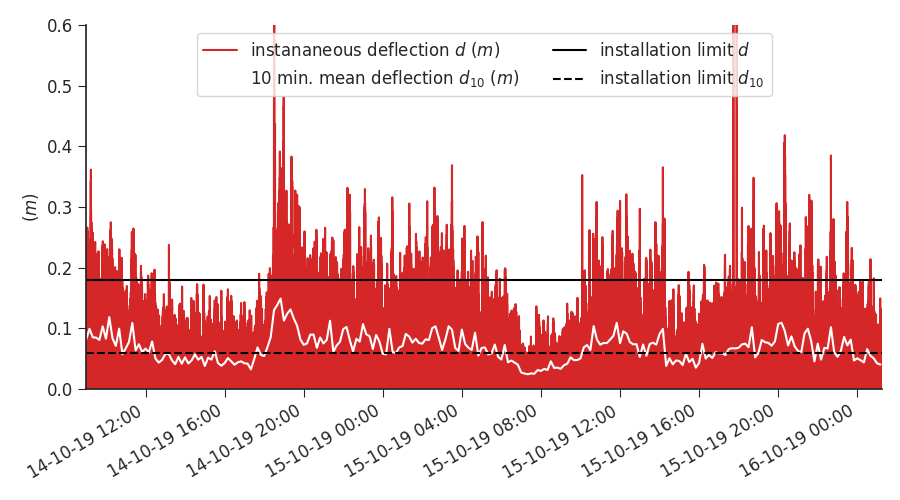

In [9]:
plt.figure(figsize=(9,5))
plt.plot(BW57.deflection, color='tab:red', label='instananeous deflection $d ~ (m)$')
plt.plot(BW57.deflection.resample('10min').mean(), color='white', label='10 min. mean deflection $d_{10} ~ (m)$')
plt.axhline(y=0.18, label='installation limit $d$', color='k')
plt.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
plt.ylabel('$(m)$')
plt.legend(loc='upper center', ncol=2, frameon=True, fancybox=True)
plt.ylim([0,0.6])
plt.xlim([BW57.index[0], BW57.index[-1]])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
#ax2 = ax.twinx()
#ax2.plot(BW57_SBIT.elevation.resample('10min').mean(), color='tab:blue')
plt.gcf().autofmt_xdate()
plt.tight_layout()
# plt.savefig('FIG3_turbine_noTMD.png',dpi=150)
plt.savefig('FIG3_turbine_noTMD.svg')


<IPython.core.display.Javascript object>


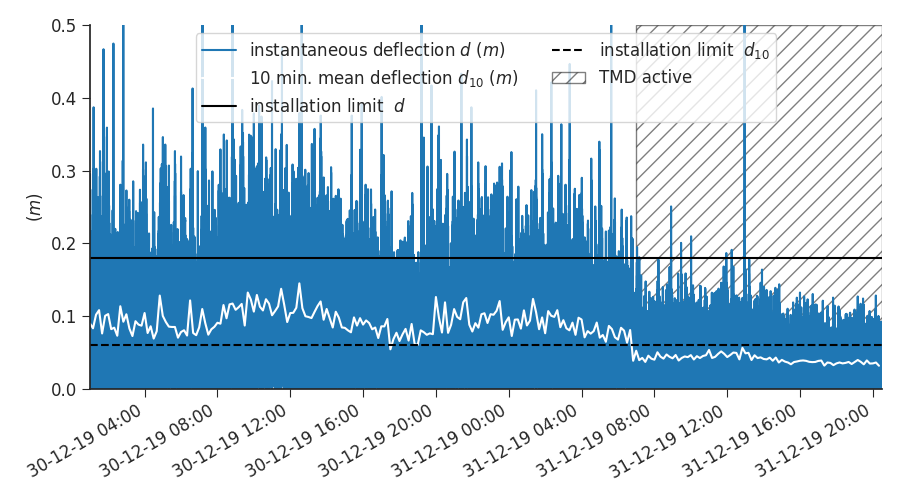

In [11]:
BW20_start = pd.to_datetime('2019-12-30 01:00').tz_localize('utc')

tmd_on = pd.to_datetime('2019-12-31 07:00').tz_localize('utc')
tmd_off=pd.to_datetime('2019-12-31 20:30').tz_localize('utc')

plt.figure(figsize=(9,5))
plt.axvspan(tmd_on, tmd_off, fill=False, alpha = 0.5, edgecolor='k', hatch='//' , label='TMD active')
plt.plot(BW20.deflection, color='tab:blue', label='instantaneous deflection $d ~ (m)$')
plt.plot(BW20.deflection.resample('10min').mean(), color='white', label='10 min. mean deflection $d_{10} ~ (m)$')
plt.axhline(y=0.18, label='installation limit  $d$', color='k')
plt.axhline(y=0.06, label='installation limit  $d_{10}$', color='k', ls='--')
plt.ylabel('$(m)$')
plt.legend(loc='upper center', ncol=2, frameon=True, fancybox=True)
plt.ylim([0,0.5])
plt.xlim([BW20.index[0], BW20.index[-1]])
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
plt.gcf().autofmt_xdate()
plt.tight_layout()
# plt.savefig('FIG3_turbine_TMD.png',dpi=150)
plt.savefig('FIG3_turbine_TMD.svg')

### FIG4: Scatter plots

<IPython.core.display.Javascript object>


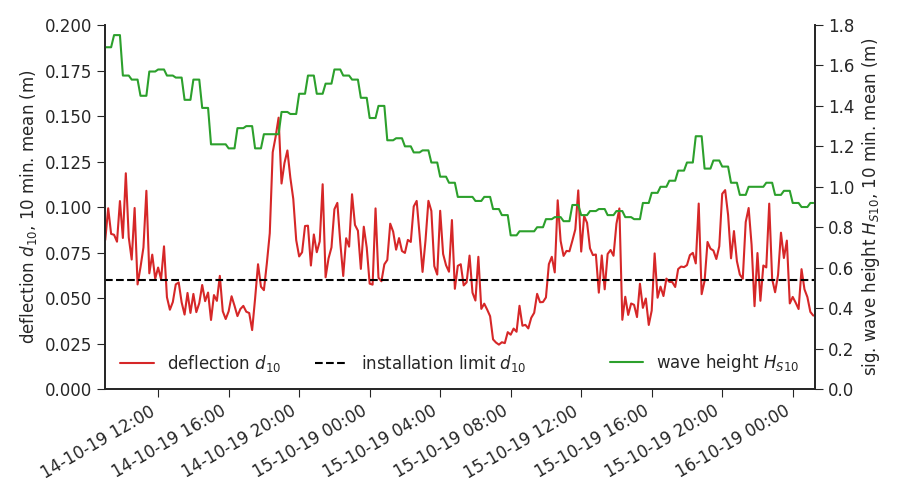

In [80]:
mpl.rcParams['axes.spines.right'] = True
plt.figure(figsize=(9,5))
ax1 = plt.gca()
ax1.plot(turbines['BW57'].deflection.resample('10min').mean(), color='tab:red', label='deflection $d_{10}$')
ax1.set_ylim([0, 0.2])
ax1.set_ylabel('deflection $d_{10}$, 10 min. mean (m)')
ax1.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
plt.legend(loc='lower left', ncol=2)
ax2 = ax1.twinx()
ax2.plot(turbines['BW57'].Hs.resample('10min').mean(), color='tab:green', label='wave height $H_{S10}$')
ax2.set_ylim([0,1.8])
#plt.xlim([BW20.index[0], BW20.index[-1]])

plt.legend(loc='lower right')

ax2.set_xlim(turbines['BW57'].index[0], turbines['BW57'].index[-1])
ax2.set_ylabel('sig. wave height $H_{S10}$, 10 min. mean (m)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.savefig('time_series_comparison_HS.png')


<IPython.core.display.Javascript object>


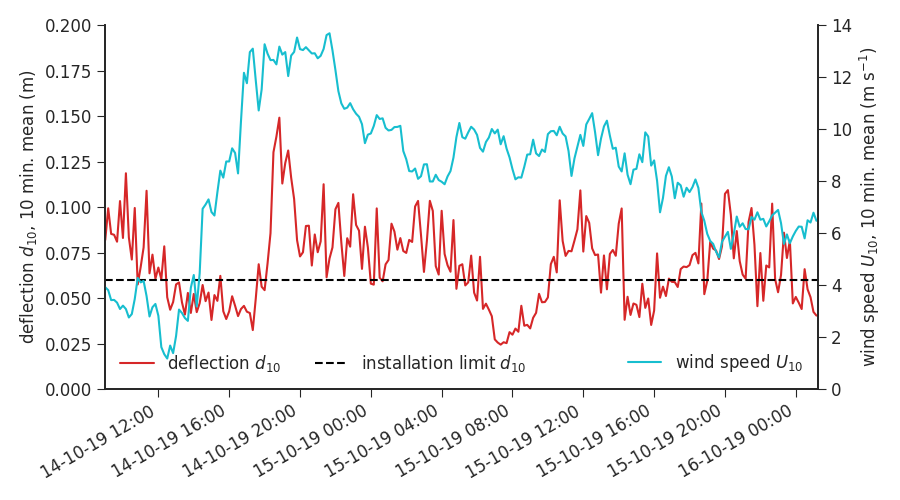

In [79]:
mpl.rcParams['axes.spines.right'] = True
plt.figure(figsize=(9,5))
ax1 = plt.gca()
ax1.plot(turbines['BW57'].deflection.resample('10min').mean(), color='tab:red', label='deflection $d_{10}$')
ax1.set_ylim([0, 0.2])
ax1.set_ylabel('deflection $d_{10}$, 10 min. mean (m)')
ax1.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
plt.legend(loc='lower left', ncol=2)
ax2 = ax1.twinx()
ax2.plot(turbines['BW57'].wind_speed.resample('10min').mean(), color='tab:cyan', label='wind speed $U_{10}$')
ax2.set_ylim([0,14])
#plt.xlim([BW20.index[0], BW20.index[-1]])

plt.legend(loc='lower right')

ax2.set_xlim(turbines['BW57'].index[0], turbines['BW57'].index[-1])
ax2.set_ylabel('wind speed $U_{10}$, 10 min. mean (m s$^{-1}$)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.savefig('time_series_comparison_U.png')


<IPython.core.display.Javascript object>


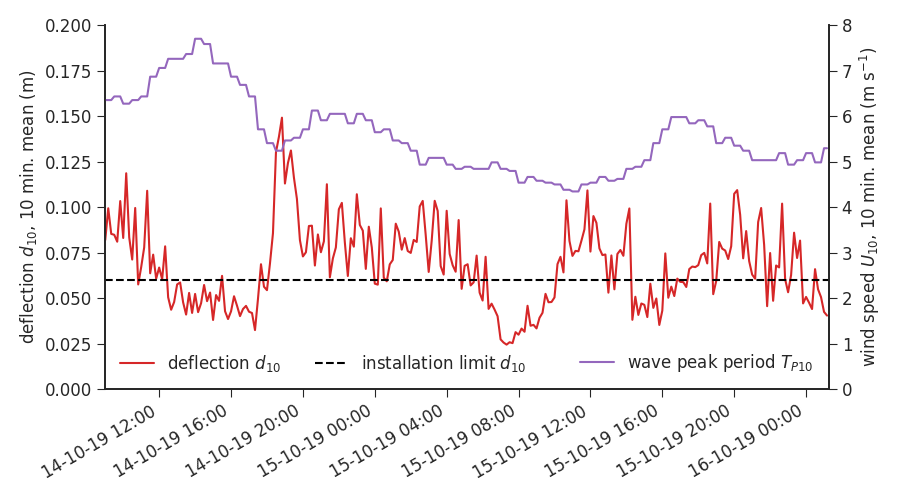

In [78]:
mpl.rcParams['axes.spines.right'] = True
plt.figure(figsize=(9,5))
ax1 = plt.gca()
ax1.plot(turbines['BW57'].deflection.resample('10min').mean(), color='tab:red', label='deflection $d_{10}$')
ax1.set_ylim([0, 0.2])
ax1.set_ylabel('deflection $d_{10}$, 10 min. mean (m)')
ax1.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
plt.legend(loc='lower left', ncol=2)
ax2 = ax1.twinx()
ax2.plot(turbines['BW57'].Tz.resample('10min').mean()*1.27, color='tab:purple', label='wave peak period $T_{P10}$')
ax2.set_ylim([0,8])
#plt.xlim([BW20.index[0], BW20.index[-1]])

plt.legend(loc='lower right')

ax2.set_xlim(turbines['BW57'].index[0], turbines['BW57'].index[-1])
ax2.set_ylabel('wind speed $U_{10}$, 10 min. mean (m s$^{-1}$)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.savefig('time_series_comparison_Tp.png')


<IPython.core.display.Javascript object>


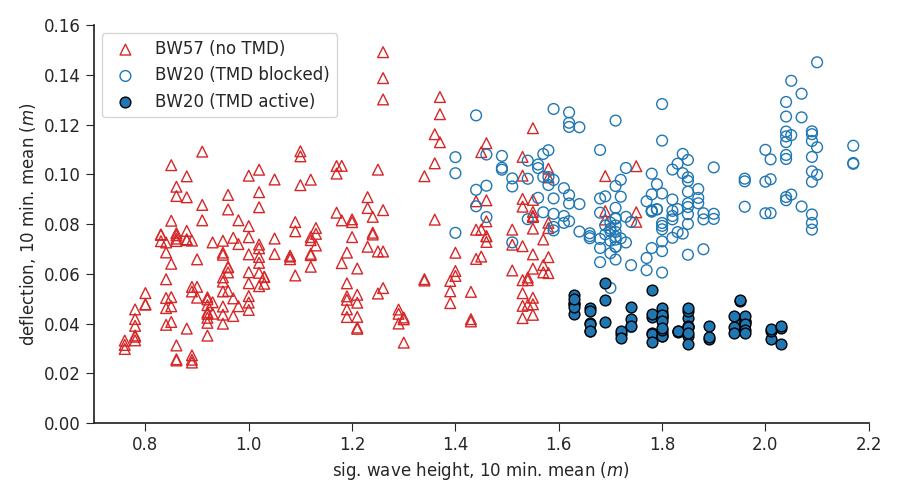

In [12]:
plt.figure(figsize=(9,5))

plt.scatter(turbines['BW57'].Hs.resample('10min').mean(),
            turbines['BW57'].deflection.resample('10min').mean(),
            color='',
            s=60,
            edgecolor='tab:red',
            marker='^',
            label='BW57 (no TMD)',
           )

plt.scatter(BW20[BW20_start:tmd_on].Hs.resample('10min').mean(),
            BW20[BW20_start:tmd_on].deflection.resample('10min').mean(),
            color='',
            s=60,
            edgecolor='tab:blue',
            label='BW20 (TMD blocked)'
            
           )

plt.scatter(turbines_tmd['BW20'].Hs.resample('10min').mean(),
            turbines_tmd['BW20'].deflection.resample('10min').mean(),
            color='tab:blue',
            edgecolor='k',
            s=60,
            label='BW20 (TMD active)'
           )


#lelem = [Line2D([0], [0], marker='o', color='tab:purple', label='no TMD', markerfacecolor='w', markersize=8, ls=''),
#         Line2D([0], [0], marker='o', color='k', label='TMD active', markerfacecolor='tab:purple', markersize=8, ls='')
#        ]
plt.legend(frameon=True, fancybox=True)

plt.ylim([0,0.16])
plt.xlim([0.7,2.2])
plt.xlabel('sig. wave height, 10 min. mean $(m)$')
plt.ylabel('deflection, 10 min. mean $(m)$')
plt.tight_layout()
plt.savefig('FIG3_scatter_comparison.png')

### calculate correlations

In [13]:
df = pd.concat([turbines[k] for k in turbines])

In [14]:
df_tmd = pd.concat([turbines_tmd[k] for k in turbines_tmd])

In [15]:
Hs10 = df.Hs.resample('10min').mean()
d10 = df.deflection.resample('10min').mean()
d10dt = df.deflection_gradient.resample('10min').mean()
s10 = df.deflection.resample('10min').std()
U10 = df.wind_speed.resample('10min').mean()
Tp10 = df.Tz.resample('10min').mean()*1.28

s10.rename('deflection_std', inplace=True)

Hs10.dropna(inplace=True)
d10.dropna(inplace=True)
U10.dropna(inplace=True)
Tp10.dropna(inplace=True)
s10.dropna(inplace=True)
d10dt.dropna(inplace=True)

df10 = pd.merge(d10, U10, how='inner', left_index=True, right_index=True)
df10 = pd.merge(df10, s10, how='inner', left_index=True, right_index=True)
df10 = pd.merge(df10, d10dt, how='inner', left_index=True, right_index=True)
df10 = pd.merge(df10, Hs10, how='inner', left_index=True, right_index=True)
df10 = pd.merge(df10, Tp10, how='inner', left_index=True, right_index=True)

waveCorr = linCorr(*linregress(df10.Hs.values, df10.deflection.values))
windCorr = linCorr(*linregress(df10.wind_speed.values, df10.deflection.values))
windWaveCorr = linCorr(*linregress(df10.wind_speed.values, df10.Hs.values))

d10_waveModel = df10.deflection / (waveCorr.slope * df10.Hs + waveCorr.intercept)
d10_windModel = df10.deflection / (windCorr.slope * df10.wind_speed + windCorr.intercept)

df10.insert(column='d10_waveModel', value=d10_waveModel, loc=4)
df10.insert(column='d10_windModel', value=d10_windModel, loc=5)

df10.rename(columns={"deflection": "d10", 
                     "wind_speed": "U10",
                     "Hs" : "Hs10",
                     "Tz" : "Tp10",
                    }, inplace=True)
del(Hs10, d10, U10, Tp10, s10, d10dt)

In [58]:
Hs10 = df_tmd.Hs.resample('10min').mean()
d10 = df_tmd.deflection.resample('10min').mean()
d10dt = df_tmd.deflection_gradient.resample('10min').mean()
s10 = df_tmd.deflection.resample('10min').std()
U10 = df_tmd.wind_speed.resample('10min').mean()
Tp10 = df_tmd.Tz.resample('10min').mean()*1.28

s10.rename('deflection_std', inplace=True)

Hs10.dropna(inplace=True)
d10.dropna(inplace=True)
U10.dropna(inplace=True)
Tp10.dropna(inplace=True)
s10.dropna(inplace=True)
d10dt.dropna(inplace=True)


df10_tmd = pd.merge(d10, U10, how='inner', left_index=True, right_index=True)
df10_tmd = pd.merge(df10_tmd, s10, how='inner', left_index=True, right_index=True)
df10_tmd = pd.merge(df10_tmd, d10dt, how='inner', left_index=True, right_index=True)
df10_tmd = pd.merge(df10_tmd, Hs10, how='inner', left_index=True, right_index=True)
df10_tmd = pd.merge(df10_tmd, Tp10, how='inner', left_index=True, right_index=True)

waveCorr_tmd = linCorr(*linregress(df10_tmd.Hs.values, df10_tmd.deflection.values))
windCorr_tmd = linCorr(*linregress(df10_tmd.wind_speed.values, df10_tmd.deflection.values))
windWaveCorr_tmd = linCorr(*linregress(df10_tmd.wind_speed.values, df10_tmd.Hs.values))

d10_tmd_waveModel = df10_tmd.deflection / (waveCorr_tmd.slope * df10_tmd.Hs + waveCorr_tmd.intercept)
d10_tmd_windModel = df10_tmd.deflection / (windCorr_tmd.slope * df10_tmd.wind_speed + windCorr_tmd.intercept)

df10_tmd.insert(column='d10_waveModel', value=d10_tmd_waveModel, loc=4)
df10_tmd.insert(column='d10_windModel', value=d10_tmd_windModel, loc=5)

df10_tmd.rename(columns={"deflection": "d10", 
                     "wind_speed": "U10",
                     "Hs" : "Hs10",
                     "Tz" : "Tp10",
                    }, inplace=True)
del(Hs10, d10, U10, Tp10, s10, d10dt)

<IPython.core.display.Javascript object>


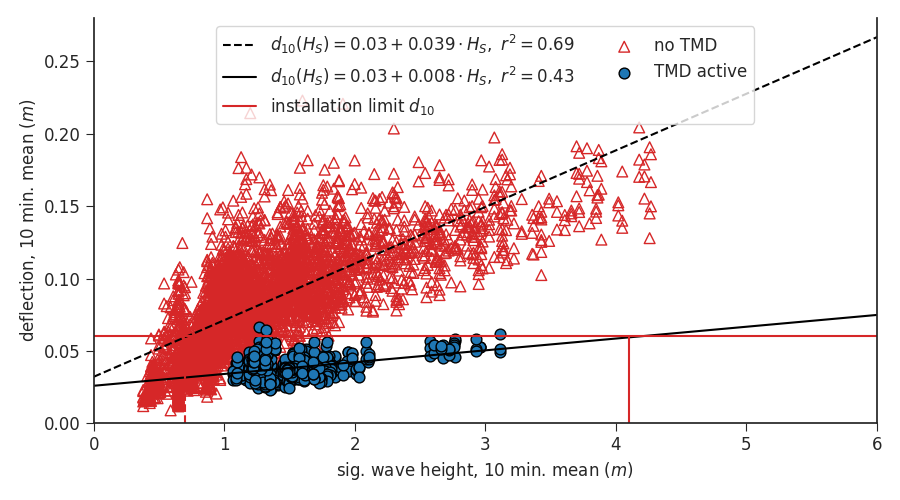

In [67]:
plt.figure(figsize=(9,5))

l1 = plt.plot([x for x in range(0, 8)],
         [(waveCorr.intercept + waveCorr.slope*x) for x in range(0, 8)],
         label='$d_{10}(H_{S})$'+'$ = {:1.2f} + {:1.3f} \cdot H_S, ~r^2 = {:1.2f}$'.format(waveCorr.intercept,
                                                                                     waveCorr.slope, 
                                                                                     waveCorr.r_value),
         color='k',
         ls='--'
        )

l2 = plt.plot([x for x in range(0, 8)],
         [(waveCorr_tmd.intercept + waveCorr_tmd.slope*x) for x in range(0, 8)],
         label='$d_{10}(H_{S})$'+'$ = {:1.2f} + {:1.3f} \cdot H_S, ~r^2 = {:1.2f}$'.format(waveCorr_tmd.intercept,
                                                                                     waveCorr_tmd.slope, 
                                                                                     waveCorr_tmd.r_value),
         color='k',
        )

plt.scatter(df10.Hs10,
            df10.d10,
            color='',
            marker='^',
            s=60,
            edgecolor='tab:red',
            label='no TMD'
           )

plt.scatter(BW20.Hs.resample('10min').mean()[BW20_start:tmd_on],
            BW20.deflection.resample('10min').mean()[BW20_start:tmd_on],
            color='',
            marker='^',
            s=60,
            edgecolor='tab:red',
           )
            

plt.scatter(df10_tmd.Hs10,
            df10_tmd.d10,
            color='tab:blue',
            s=60,
            edgecolor='k',
            label='TMD active'
           )

plt.axhline(y=0.06, label='installation limit $d_{10}$', color='tab:red')
plt.plot([0.7, 0.7], [0, 0.06], color='tab:red', ls='--')
plt.plot([4.1, 4.1], [0, 0.06], color='tab:red')

plt.legend(frameon=True, fancybox=True, ncol=2, loc='upper center')


plt.ylim([0,0.28])
plt.xlim([0,6])
plt.xlabel('sig. wave height, 10 min. mean $(m)$')
plt.ylabel('deflection, 10 min. mean $(m)$')
plt.tight_layout()
plt.savefig('FIG4_d10_Hs10.png')

<IPython.core.display.Javascript object>


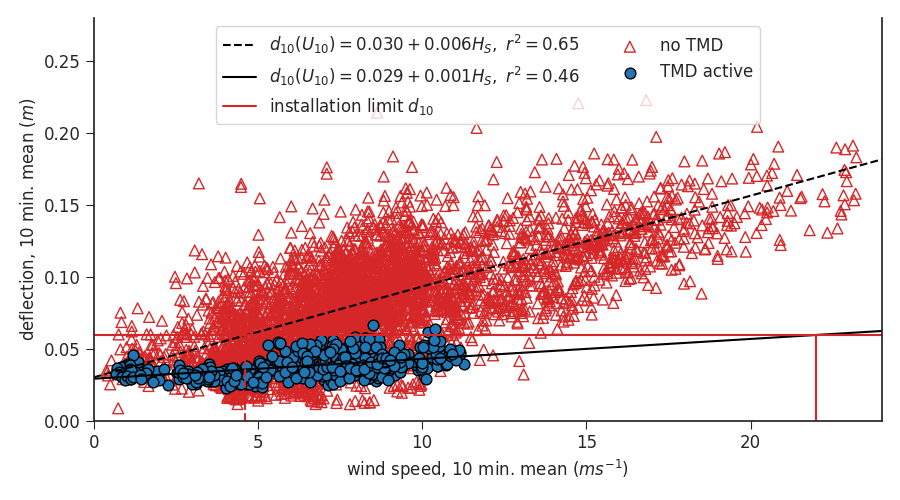

In [69]:
plt.figure(figsize=(9,5))

plt.scatter(df10.U10,
            df10.d10,
            color='',
            marker='^',
            s=60,
            edgecolor='tab:red',
            label='no TMD'
           )

plt.scatter(BW20.wind_speed.resample('10min').mean()[BW20_start:tmd_on],
            BW20.deflection.resample('10min').mean()[BW20_start:tmd_on],
            color='',
            marker='^',
            s=60,
            edgecolor='tab:red',
           )

plt.scatter(df10_tmd.U10,
            df10_tmd.d10,
            color='tab:blue',
            s=60,
            edgecolor='k',
            label='TMD active'
           )

plt.plot([x for x in range(0, 28)],
         [(windCorr.intercept + windCorr.slope*x) for x in range(0, 28)],
         label='$d_{10}(U_{10})$'+'$ = {:1.3f} + {:1.3f} H_S, ~r^2 = {:1.2f}$'.format(windCorr.intercept,
                                                                                     windCorr.slope, 
                                                                                     windCorr.r_value),
         color='k',
         ls='--'
        )

plt.plot([x for x in range(0, 28)],
         [(windCorr_tmd.intercept + windCorr_tmd.slope*x) for x in range(0, 28)],
         label='$d_{10}(U_{10})$'+'$ = {:1.3f} + {:1.3f} H_S, ~r^2 = {:1.2f}$'.format(windCorr_tmd.intercept,
                                                                                     windCorr_tmd.slope, 
                                                                                     windCorr_tmd.r_value),
         color='k',
        )

plt.axhline(y=0.06, label='installation limit $d_{10}$', color='tab:red')
plt.plot([4.6, 4.6], [0, 0.06], color='tab:red', ls='--')
plt.plot([22, 22], [0, 0.06], color='tab:red')

plt.legend(ncol=2, loc='upper center', frameon=True, fancybox=True)


plt.ylim([0,0.28])
plt.xlim([0,24])
plt.xlabel('wind speed, 10 min. mean $(m s^{-1})$')
plt.ylabel('deflection, 10 min. mean $(m)$')
plt.tight_layout()
plt.savefig('FIG4_d10_U10.png')

<IPython.core.display.Javascript object>


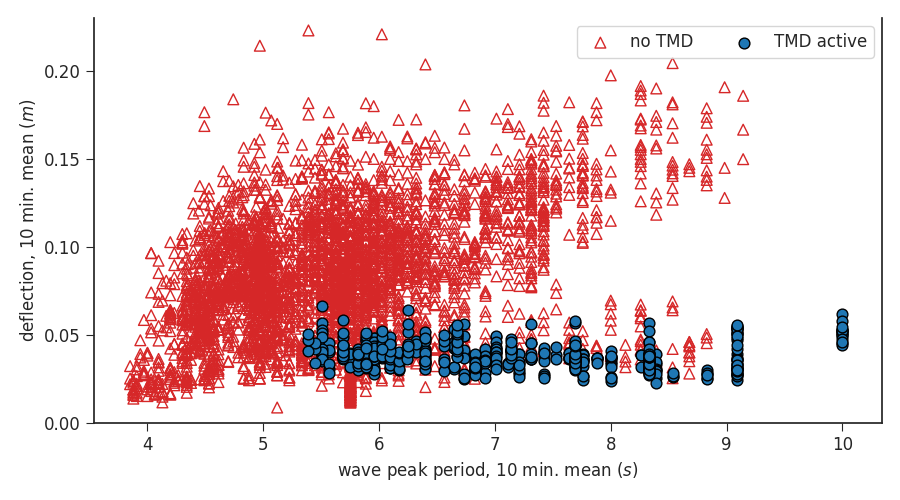

In [70]:
plt.figure(figsize=(9,5))

plt.scatter(df10.Tp10,
            df10.d10,
            color='',
            marker='^',
            s=60,
            edgecolor='tab:red',
            label='no TMD'
           )



plt.scatter(BW20.Tz.resample('10min').mean()[BW20_start:tmd_on],
            BW20.deflection.resample('10min').mean()[BW20_start:tmd_on],
            color='',
            marker='^',
            s=60,
            edgecolor='tab:red',
           )

plt.scatter(df10_tmd.Tp10,
            df10_tmd.d10,
            color='tab:blue',
            s=60,
            edgecolor='k',
            label='TMD active'
           )


plt.legend(ncol=2, loc='upper right', frameon=True, fancybox=True)


plt.ylim([0,0.23])
#plt.xlim([0,20])
plt.xlabel('wave peak period, 10 min. mean $(s)$')
plt.ylabel('deflection, 10 min. mean $(m)$')
plt.tight_layout()
plt.savefig('FIG4_d10_Tp10.png')

## Theoretical environmental limits

<IPython.core.display.Javascript object>


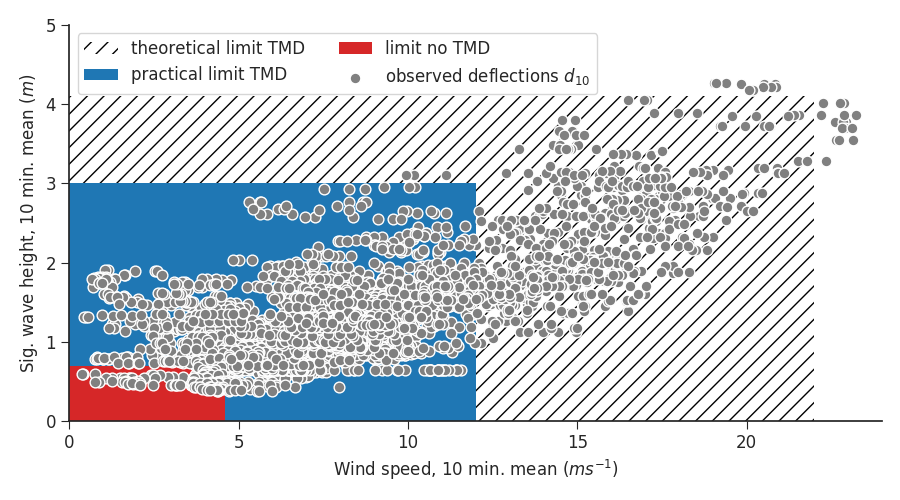

In [53]:
plt.figure(figsize=(9,5))

plt.scatter(df10.U10,
            df10.Hs10,
            color='gray',
            s=60,
            edgecolor='white',
            zorder=2,
           )

plt.scatter(BW20.wind_speed.resample('10min').mean()[BW20_start:tmd_on],
            BW20.Hs.resample('10min').mean()[BW20_start:tmd_on],
            color='gray',
            s=60,
            edgecolor='white',
            zorder=2,
           )

plt.scatter(df10_tmd.U10,
            df10_tmd.Hs10,
            color='gray',
            s=60,
            edgecolor='white',
            zorder=2,
            label='observed deflections $d_{10}$'
           )

plt.axhspan(ymin=0, ymax=4.1, xmin=0, xmax=0.91666, facecolor='white', hatch='//', alpha=1, zorder=1, label='theoretical limit TMD')
#plt.axhline(y=4.1, label='Single blade installation limits: TMD active (theoretical)', color='k')
#plt.axvline(x=22, color='k')

plt.axhspan(ymin=0, ymax=3, xmin=0, xmax=0.5, facecolor='tab:blue', alpha=1, zorder=1, label='practical limit TMD')
#plt.axhline(y=3, label='Single blade installation limits: TMD active (practical)', color='tab:blue')
#plt.axvline(x=12, color='tab:blue')

plt.axhspan(ymin=0, ymax=0.7, xmin=0, xmax=0.191, facecolor='tab:red', alpha=1, zorder=1, label='limit no TMD')
#plt.axhline(y=0.7, label='Single blade installation limits: no TMD', color='tab:red')
#plt.axvline(x=4.6, color='tab:red')



plt.legend(ncol=2, frameon=True, fancybox=True, loc='upper left')
plt.xlim([0,24])
plt.ylim([0, 5])
plt.xlabel('Wind speed, 10 min. mean $(m s^{-1})$')
plt.ylabel('Sig. wave height, 10 min. mean $(m)$')
plt.tight_layout()
plt.savefig('FIG6_EnvironemntalLimits.png')

### wind wave missalignement

<IPython.core.display.Javascript object>


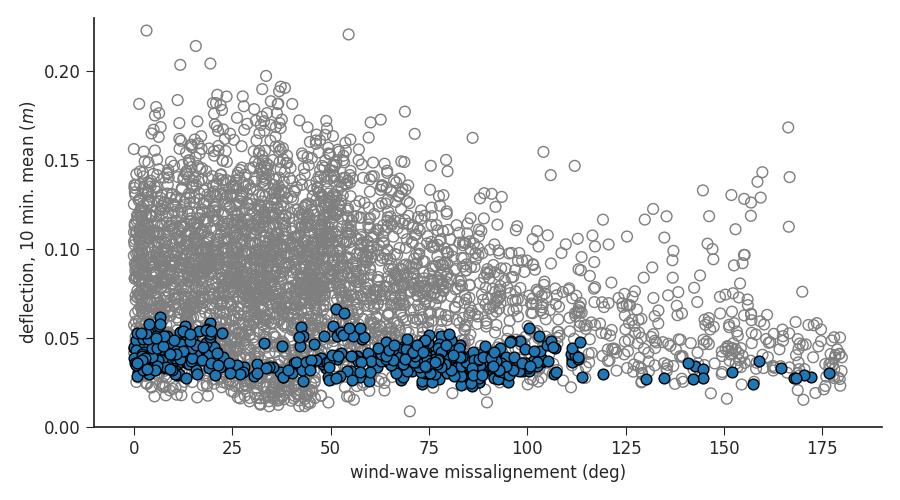

No handles with labels found to put in legend.


In [54]:
def heading(x):
    if x < 0:
        x = x*-1
    if x > 180:
        return x-180
    else:
        return x


plt.figure(figsize=(9,5))


for t in turbines:
    #if t in ('BW59',): continue
    beta = turbines[t].wave_dir.resample('10min').mean() - turbines[t].wind_dir_corr.resample('10min').mean()
    beta = beta.apply(heading)

    plt.scatter(beta,
                turbines[t].deflection.resample('10min').mean(),
                color='',
                s=60,
                edgecolor='tab:gray',
               )
    
for t in turbines_tmd:
    #if t in ('BW59',): continue
    beta = turbines_tmd[t].wave_dir.resample('10min').mean() - turbines_tmd[t].wind_dir_corr.resample('10min').mean()
    beta = beta.apply(heading)

    plt.scatter(beta,
                turbines_tmd[t].deflection.resample('10min').mean(),
                color='tab:blue',
                s=60,
                edgecolor='k',
               )

plt.ylim([0, 0.23])
plt.legend(ncol=2)
plt.xlabel('wind-wave missalignement (deg)')
plt.ylabel('deflection, 10 min. mean $(m)$')
plt.tight_layout()
plt.savefig('FIG5_wind_wave_missalignement.png')

<IPython.core.display.Javascript object>


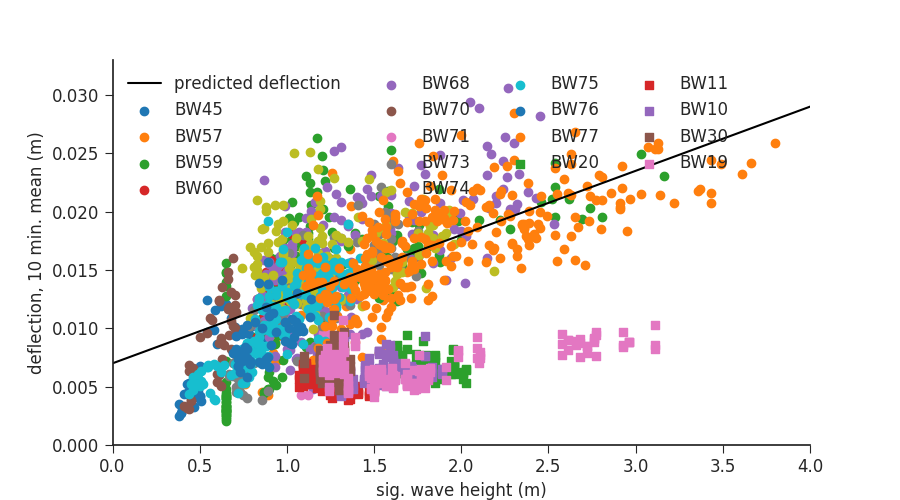

In [55]:

plt.figure(figsize=(9,5))

for bw in turbines:
    if bw in ('BW67',): continue
    l = plt.scatter(turbines[bw].Hs.resample('30min').mean(),
                    turbines[bw].deflection.resample('30min').mean()/6,
                    label=bw,
                    #color='',
                    #s=60,
                    #edgecolor='grey'
                   )
    
for bw in turbines_tmd:
    plt.scatter(turbines_tmd[bw].Hs.resample('10min').mean(),
                turbines_tmd[bw].deflection.resample('10min').mean()/6,
                label=bw,
                marker='s'
                #color='tab:blue',
               )
    
plt.plot([x for x in range(6)],
         [(0.042 + 0.033*x)/6 for x in range(6)],
         label='predicted deflection',
         color='k'
        )

plt.legend(ncol=4)

#lelem = [Line2D([0], [0], marker='o', color='grey', label='turbines w/a TMD', markerfacecolor='w', markersize=8, ls=''),
#         Line2D([0], [0], marker='o', color='tab:blue', label='turbines TMD', markersize=8, ls='')
#        ]
#plt.legend(handles=lelem)

plt.ylim([0,0.033])
plt.xlim([0,4])
plt.xlabel('sig. wave height (m)')
plt.ylabel('deflection, 10 min. mean (m)')
plt.savefig('damper_deflection.png')

<IPython.core.display.Javascript object>


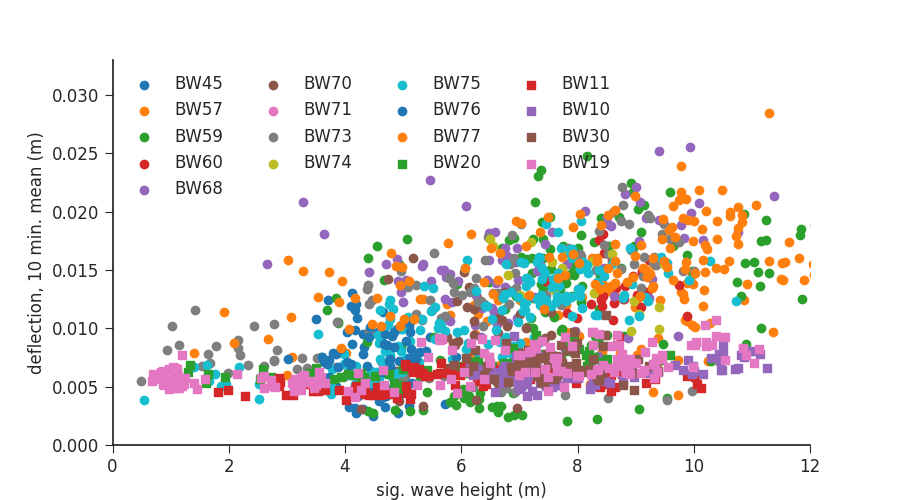

In [56]:

plt.figure(figsize=(9,5))

for bw in turbines:
    if bw in ('BW67',): continue
    l = plt.scatter(turbines[bw].wind_speed.resample('30min').mean(),
                    turbines[bw].deflection.resample('30min').mean()/6,
                    label=bw,
                    #color='',
                    #s=60,
                    #edgecolor='grey'
                   )
    
for bw in turbines_tmd:
    plt.scatter(turbines_tmd[bw].wind_speed.resample('10min').mean(),
                turbines_tmd[bw].deflection.resample('10min').mean()/6,
                label=bw,
                marker='s'
                #color='tab:blue',
               )


plt.legend(ncol=4)

#lelem = [Line2D([0], [0], marker='o', color='grey', label='turbines w/a TMD', markerfacecolor='w', markersize=8, ls=''),
#         Line2D([0], [0], marker='o', color='tab:blue', label='turbines TMD', markersize=8, ls='')
#        ]
#plt.legend(handles=lelem)

plt.ylim([0,0.033])
plt.xlim([0,12])
plt.xlabel('sig. wave height (m)')
plt.ylabel('deflection, 10 min. mean (m)')
plt.savefig('damper_deflection.png')

---

## Results
### d10 vs Hs

/home/san/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


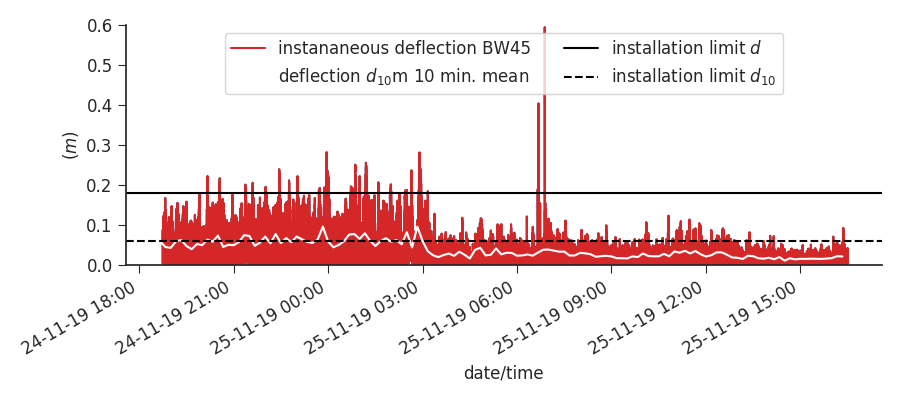

<IPython.core.display.Javascript object>


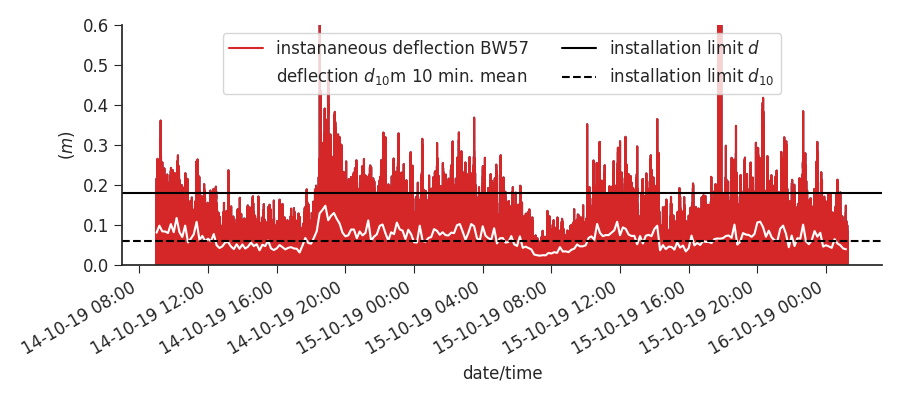

<IPython.core.display.Javascript object>


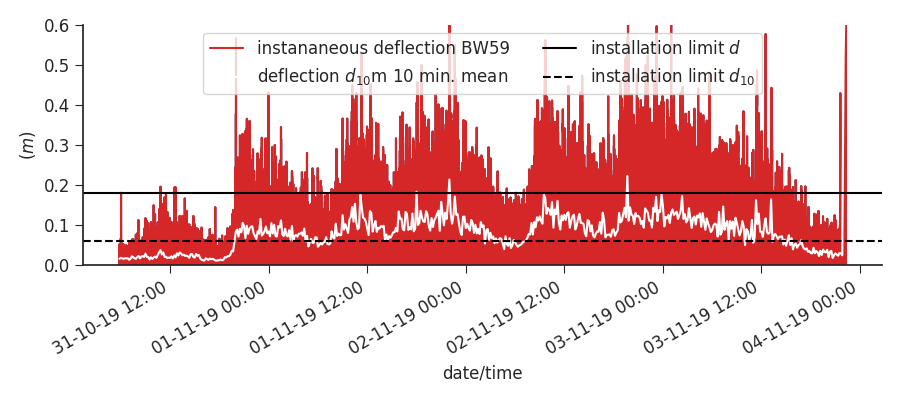

<IPython.core.display.Javascript object>


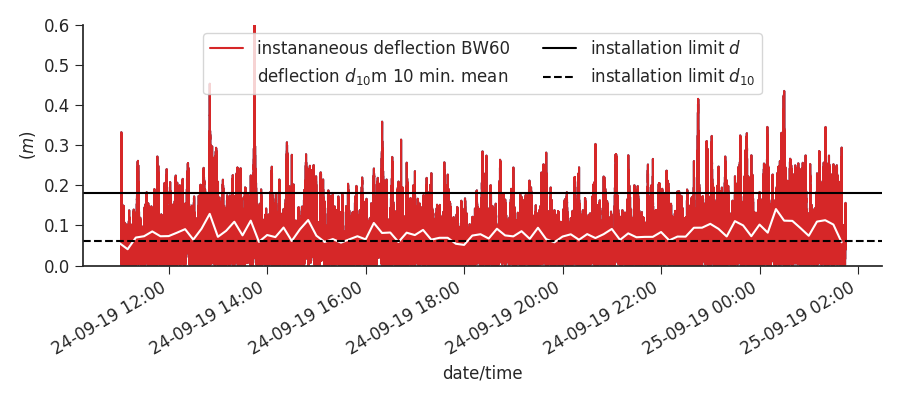

<IPython.core.display.Javascript object>


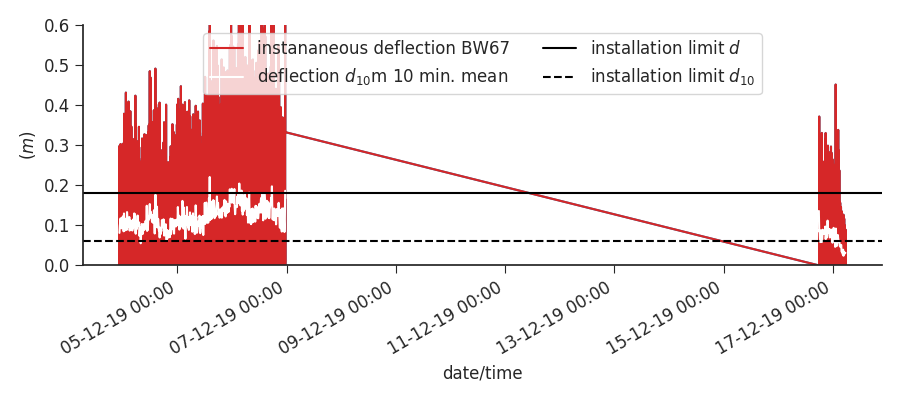

<IPython.core.display.Javascript object>


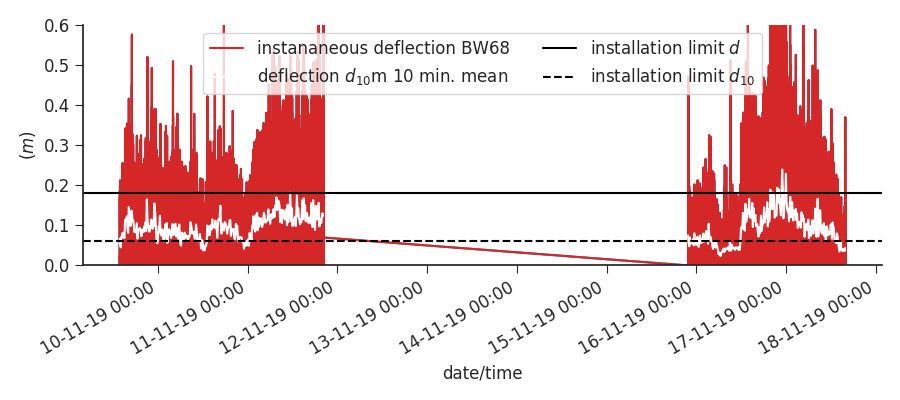

<IPython.core.display.Javascript object>


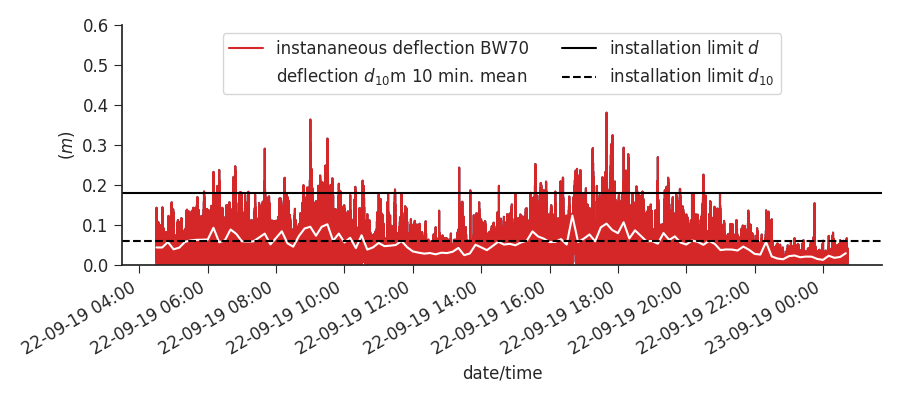

<IPython.core.display.Javascript object>


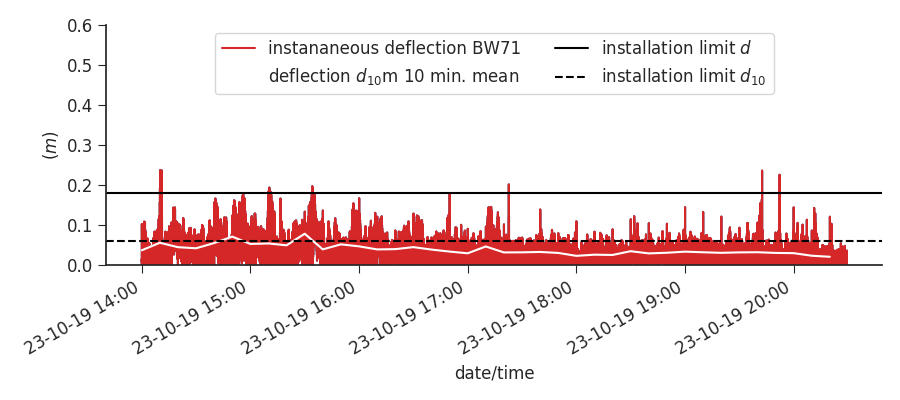

<IPython.core.display.Javascript object>


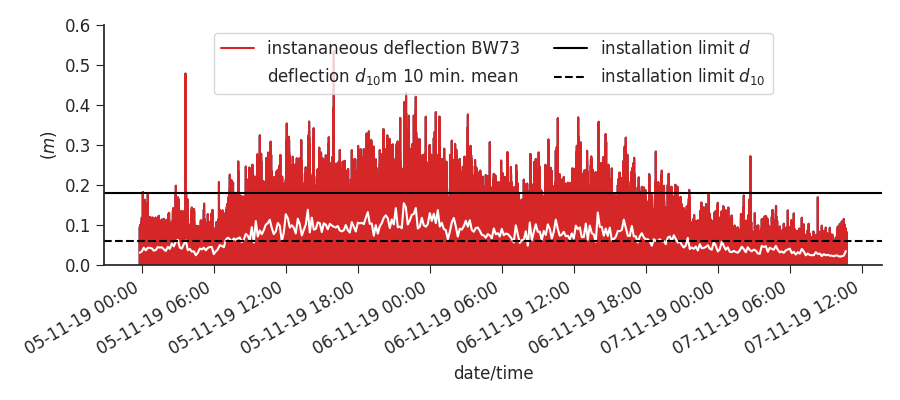

<IPython.core.display.Javascript object>


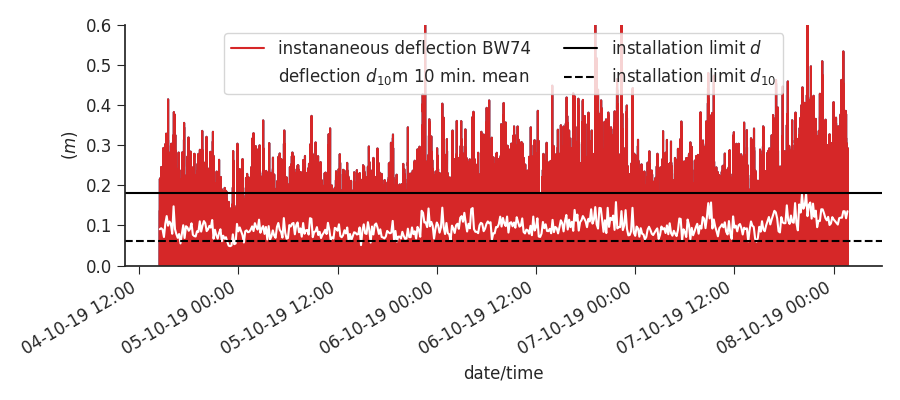

<IPython.core.display.Javascript object>


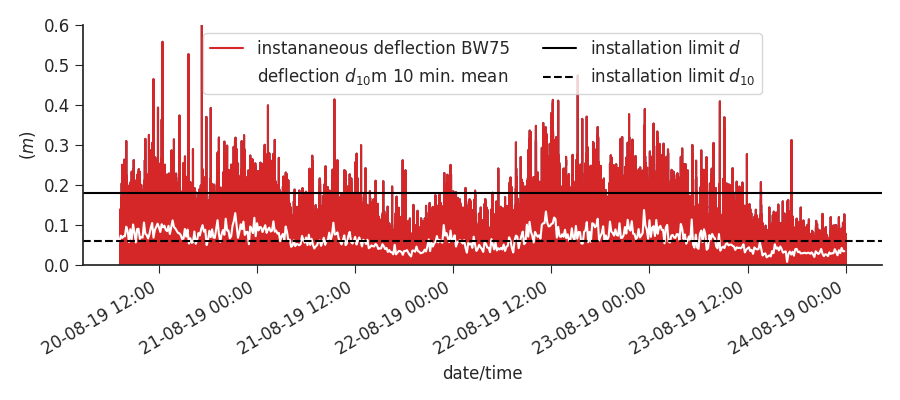

<IPython.core.display.Javascript object>


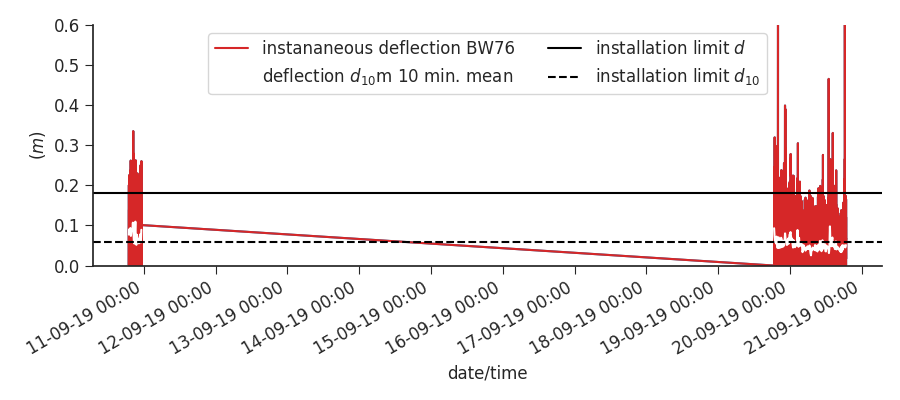

<IPython.core.display.Javascript object>


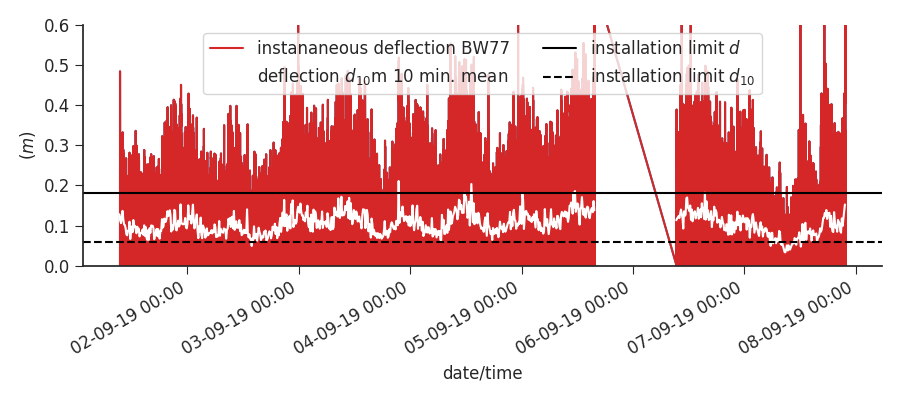

In [61]:
for t in turbines:
    plt.figure(figsize=(9,4))
    plt.plot(turbines[t].deflection)
    
    plt.plot(turbines[t].deflection, color='tab:red', label='instananeous deflection {}'.format(t))
    plt.plot(turbines[t].deflection.resample('10min').mean(), color='white', label='deflection $d_{10}$m 10 min. mean')
    plt.axhline(y=0.18, label='installation limit $d$', color='k')
    plt.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
    plt.ylabel('$(m)$')
    plt.legend(loc='upper center', ncol=2, frameon=True, fancybox=True)
    plt.xlabel('date/time')
    plt.ylim([0, 0.6])    
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.savefig('turbines/{}_noTMD.png'.format(t), dpi=150)

/home/san/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


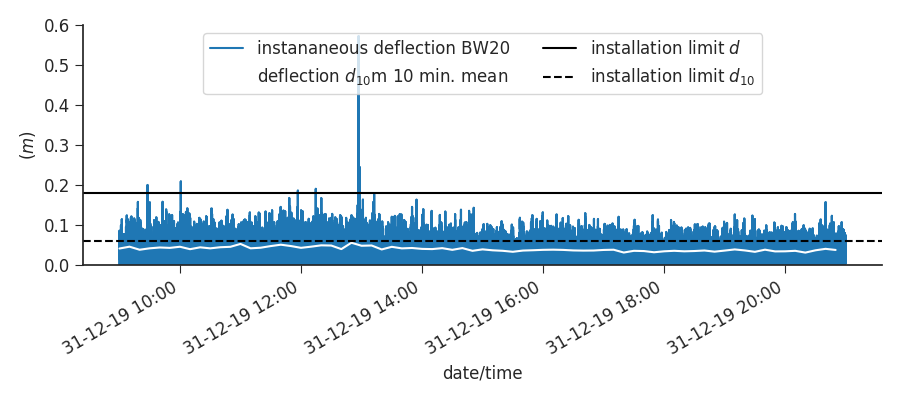

<IPython.core.display.Javascript object>


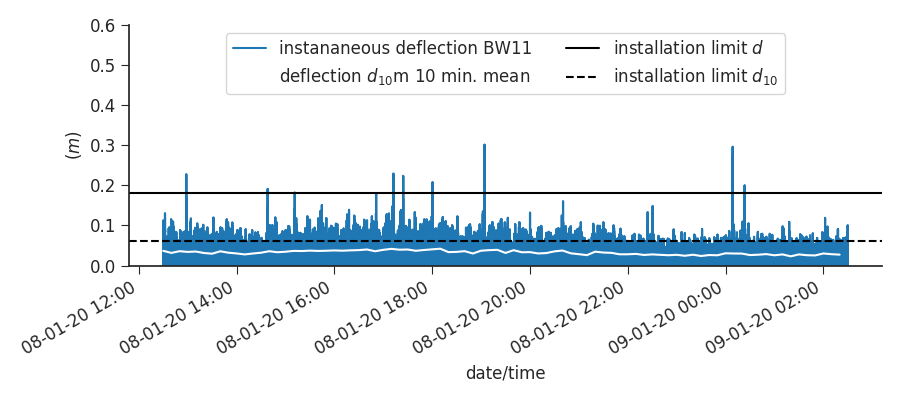

<IPython.core.display.Javascript object>


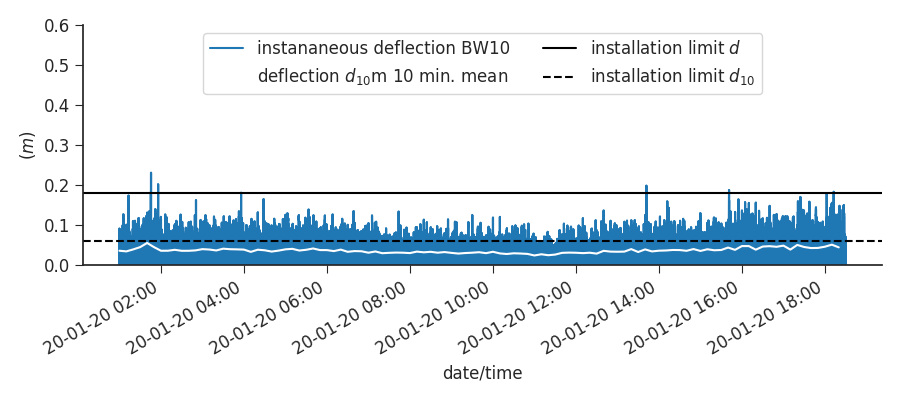

<IPython.core.display.Javascript object>


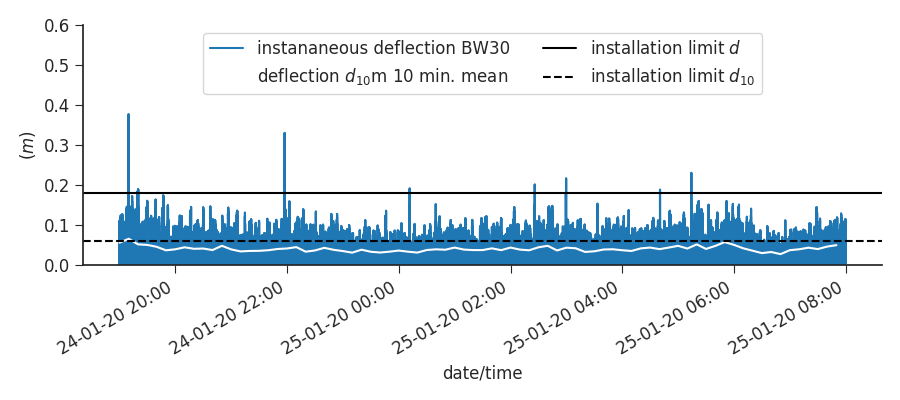

<IPython.core.display.Javascript object>


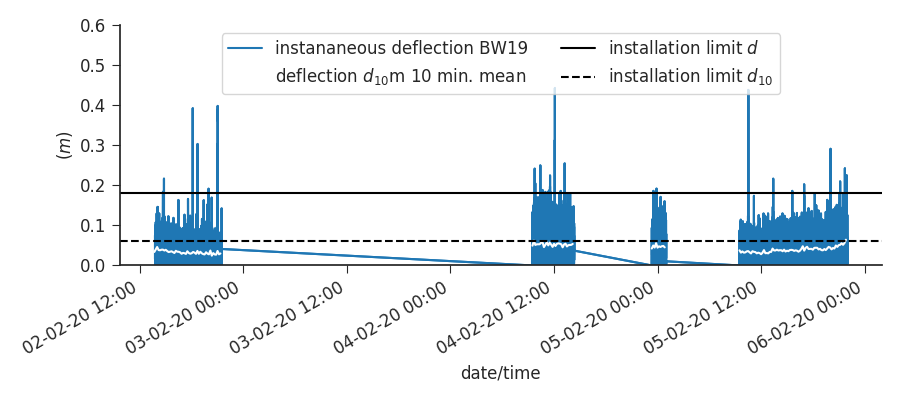

In [62]:
for t in turbines_tmd:
    plt.figure(figsize=(9,4))
    plt.plot(turbines_tmd[t].deflection)
    
    plt.plot(turbines_tmd[t].deflection, color='tab:blue', label='instananeous deflection {}'.format(t))
    plt.plot(turbines_tmd[t].deflection.resample('10min').mean(), color='white', label='deflection $d_{10}$m 10 min. mean')
    plt.axhline(y=0.18, label='installation limit $d$', color='k')
    plt.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
    plt.ylabel('$(m)$')
    plt.legend(loc='upper center', ncol=2, frameon=True, fancybox=True)
    plt.xlabel('date/time')
    plt.ylim([0, 0.6])    
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%y %H:00"))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.savefig('turbines/{}_TMD.png'.format(t), dpi=150)

/home/san/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


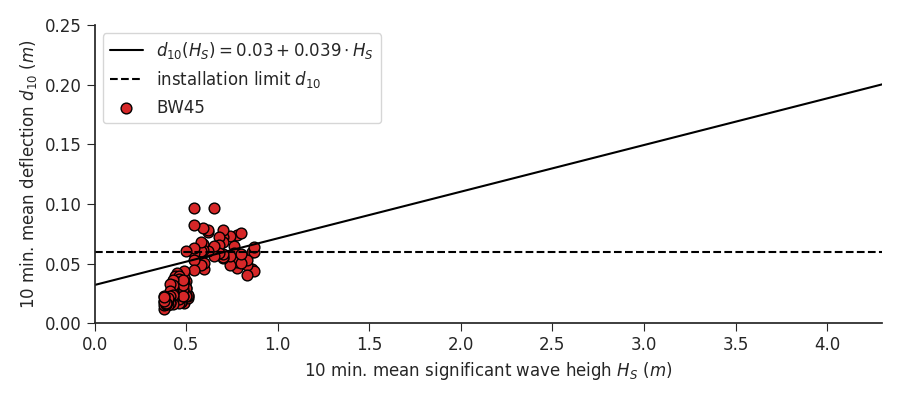

<IPython.core.display.Javascript object>


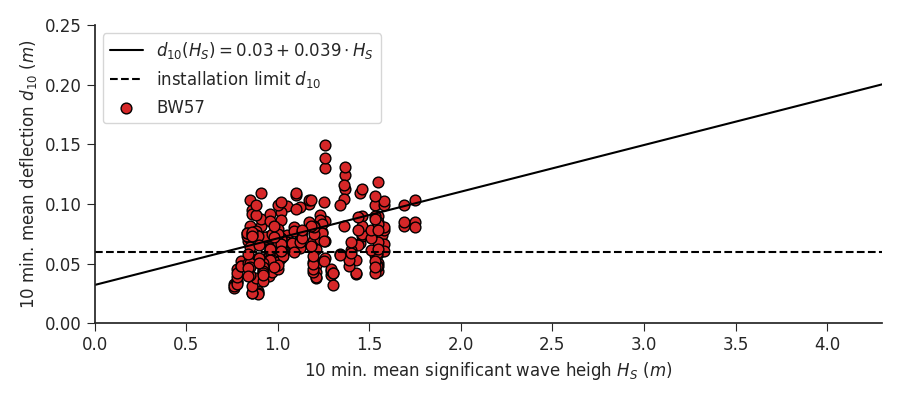

<IPython.core.display.Javascript object>


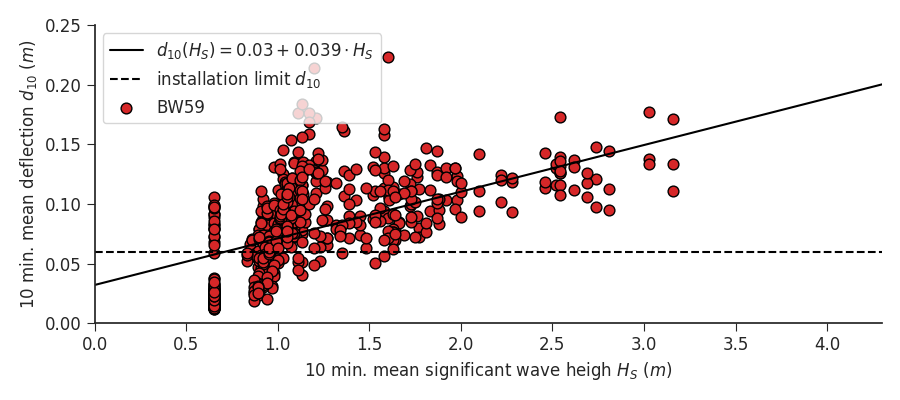

<IPython.core.display.Javascript object>


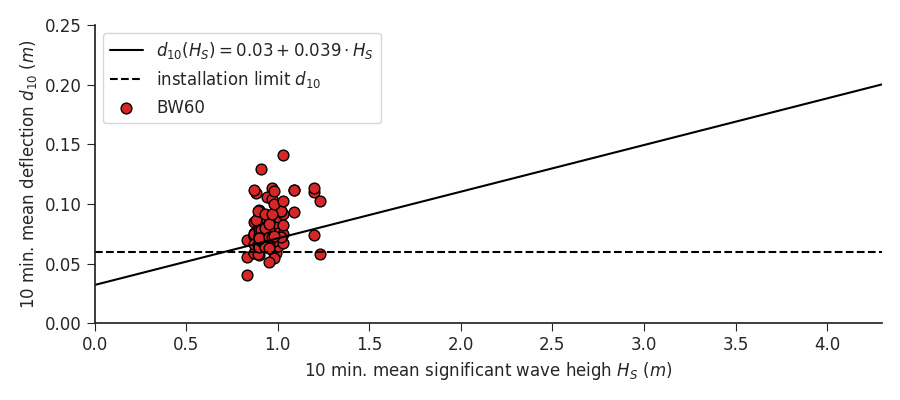

<IPython.core.display.Javascript object>


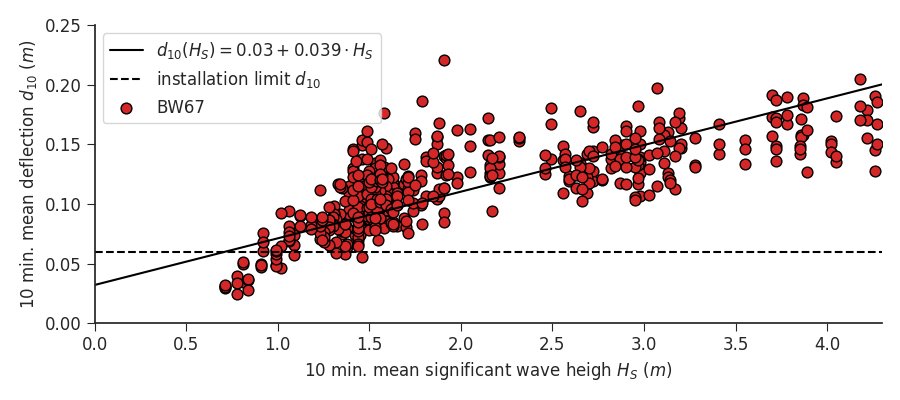

<IPython.core.display.Javascript object>


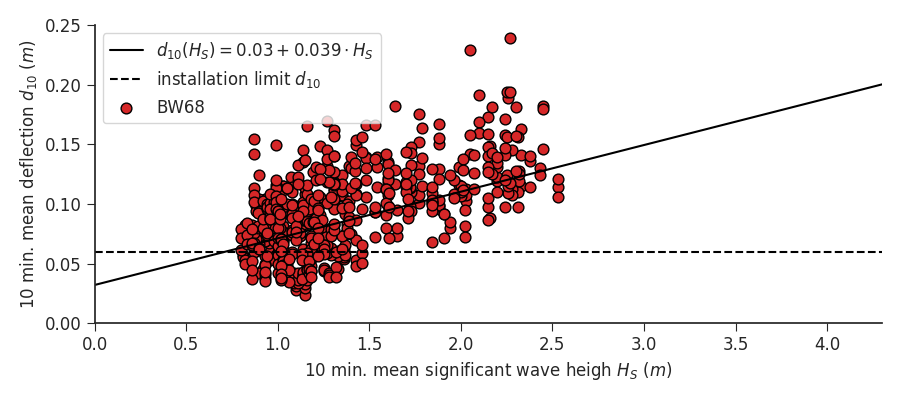

<IPython.core.display.Javascript object>


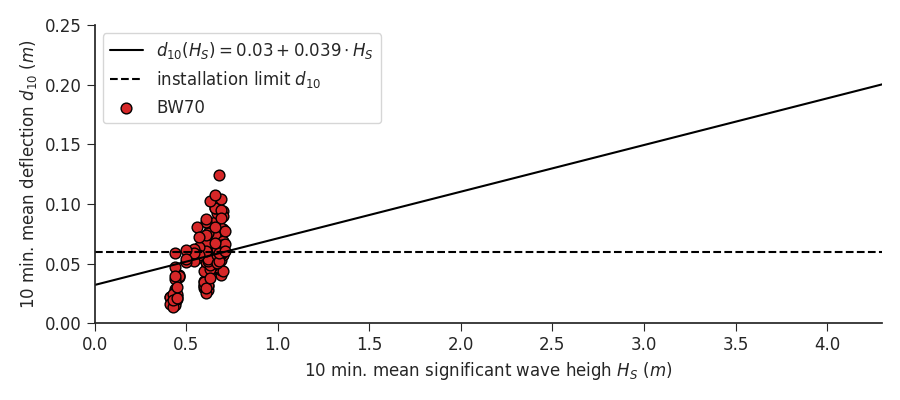

<IPython.core.display.Javascript object>


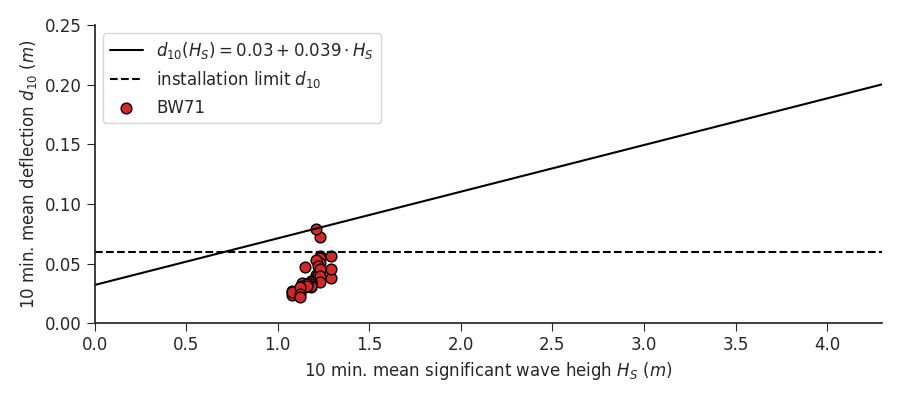

<IPython.core.display.Javascript object>


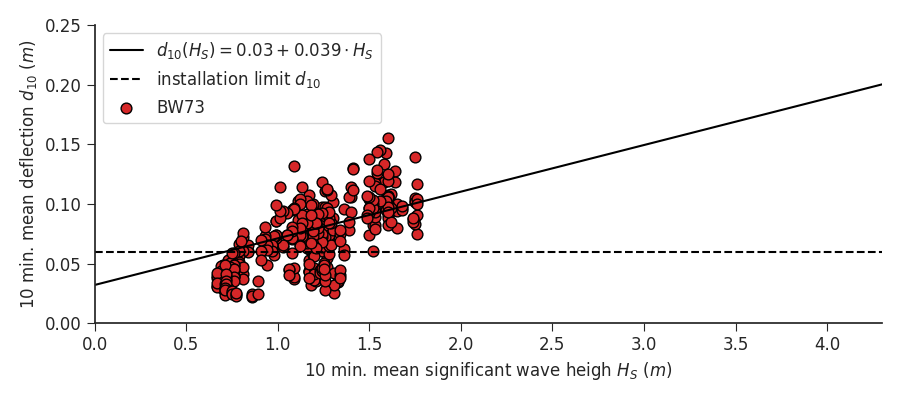

<IPython.core.display.Javascript object>


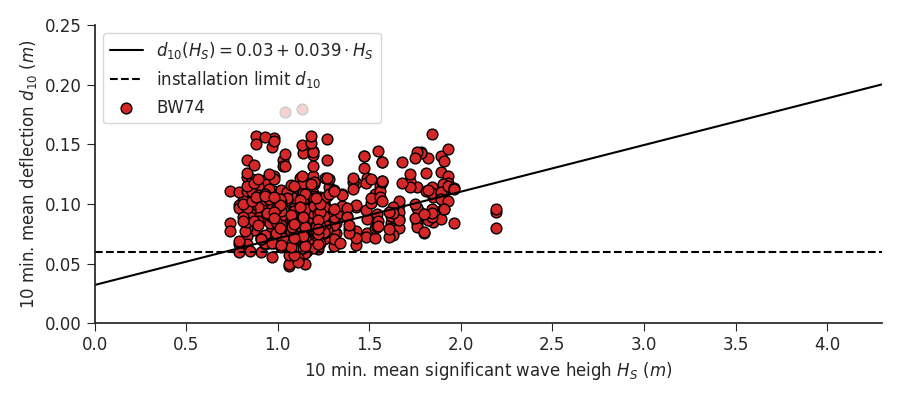

<IPython.core.display.Javascript object>


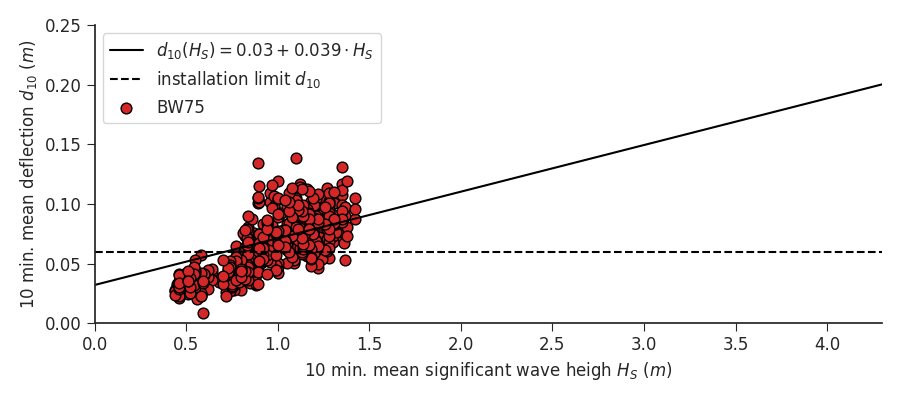

<IPython.core.display.Javascript object>


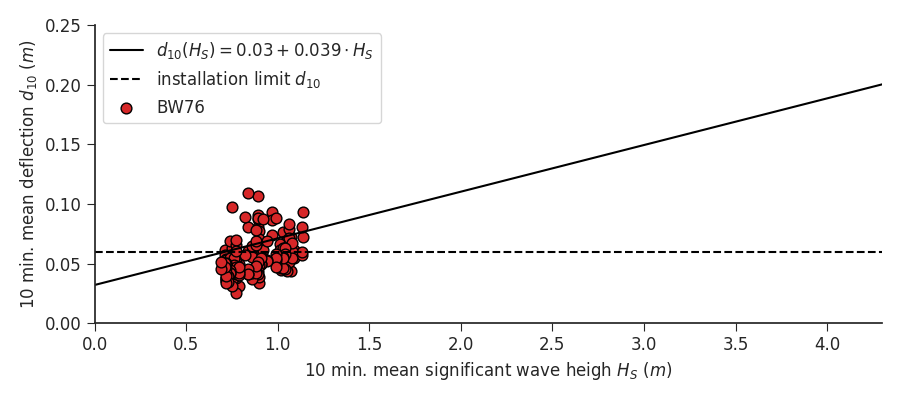

<IPython.core.display.Javascript object>


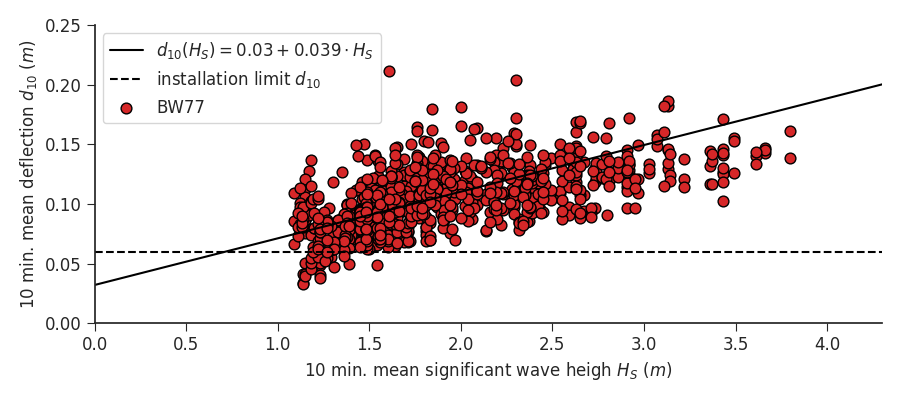

In [58]:
for t in turbines:
    plt.figure(figsize=(9,4))    
    plt.scatter(turbines[t].Hs.resample('10min').mean(),
                turbines[t].deflection.resample('10min').mean(),
                color='tab:red',
                edgecolor='k',
                label='{}'.format(t),
                s=60,
               )
    l1 = plt.plot([x for x in range(0, 8)],
         [(waveCorr.intercept + waveCorr.slope*x) for x in range(0, 8)],
         label='$d_{10}(H_{S})$'+'$ = {:1.2f} + {:1.3f} \cdot H_S $'.format(waveCorr.intercept, waveCorr.slope),
         color='k',
        )


    plt.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
    plt.ylabel('10 min. mean deflection $d_{10} ~ (m)$')
    plt.xlabel('10 min. mean significant wave heigh $H_S ~ (m)$')
    plt.ylim([0, 0.25])
    plt.xlim([0, 4.3])
    plt.legend(frameon=True, fancybox=True, loc='upper left')

    plt.tight_layout()
    plt.savefig('turbines/{}_Hs_d10_noTMD.png'.format(t), dpi=150)


/home/san/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


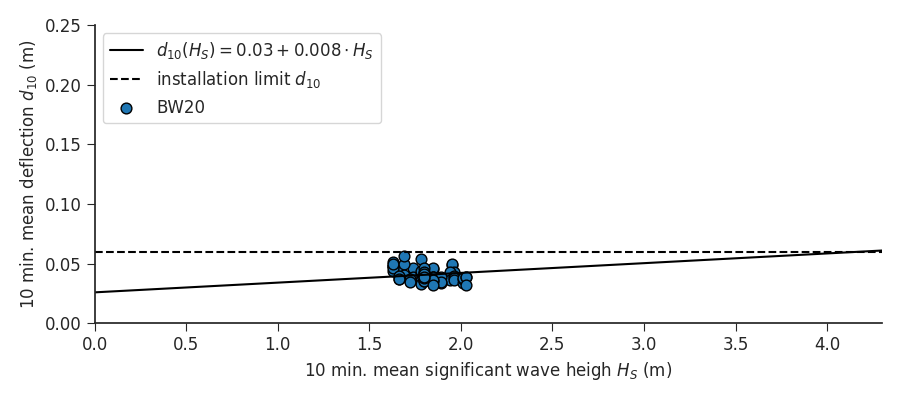

<IPython.core.display.Javascript object>


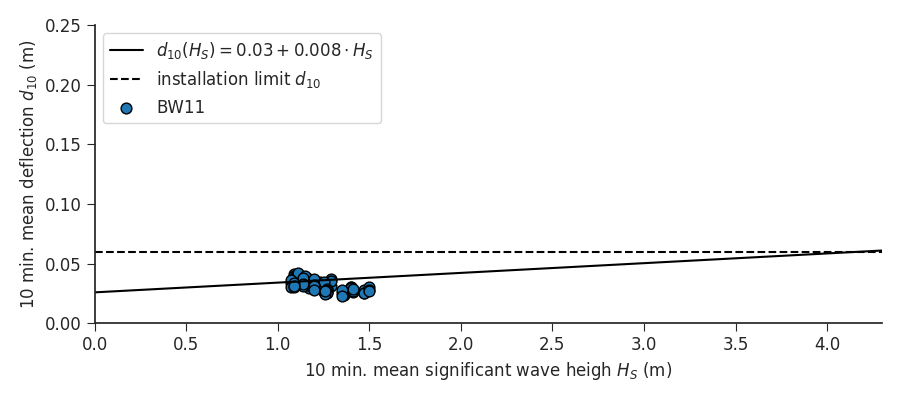

<IPython.core.display.Javascript object>


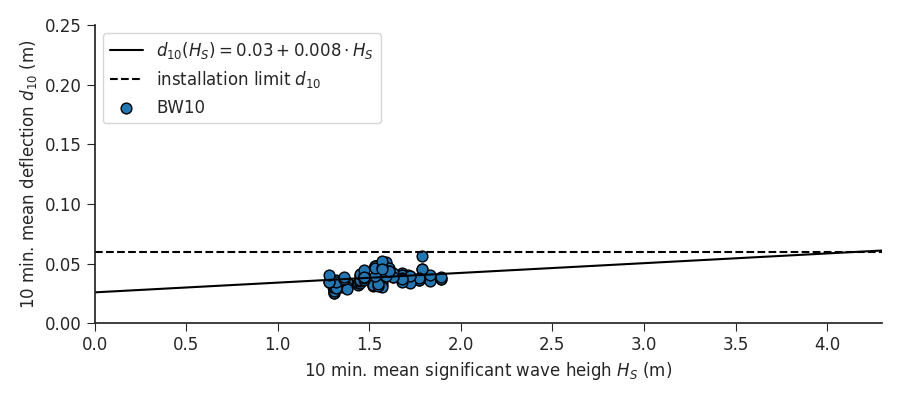

<IPython.core.display.Javascript object>


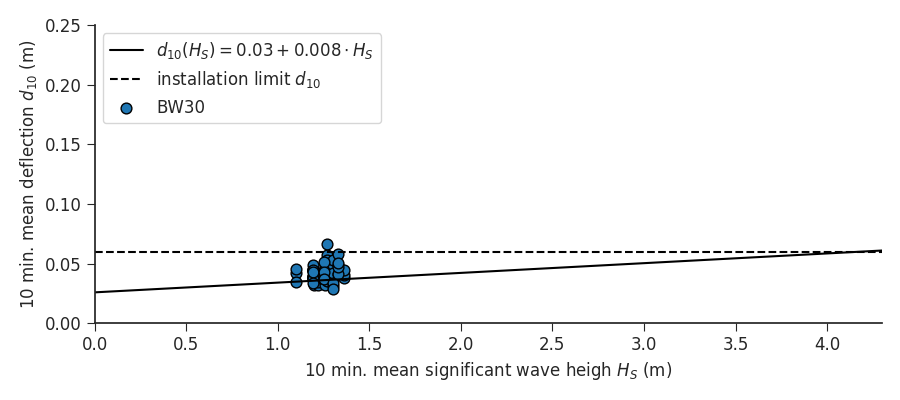

<IPython.core.display.Javascript object>


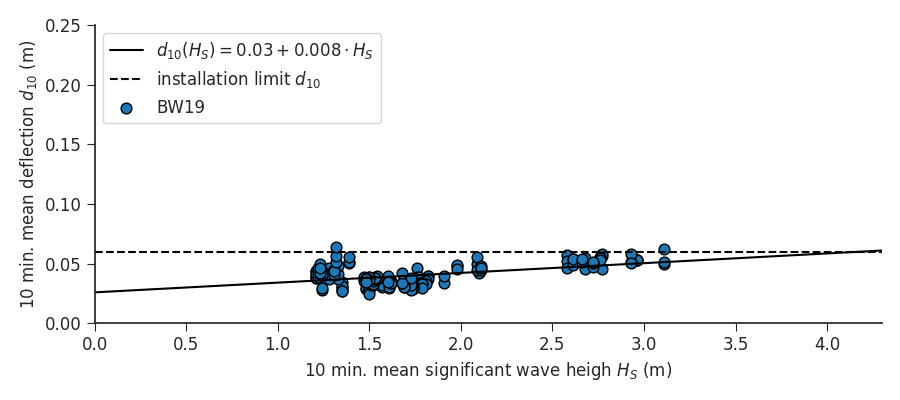

In [59]:
for t in turbines_tmd:
    plt.figure(figsize=(9,4))    
    plt.scatter(turbines_tmd[t].Hs.resample('10min').mean(),
             turbines_tmd[t].deflection.resample('10min').mean(),
             color='tab:blue',
                edgecolor='k',
                label='{}'.format(t),
                s=60,
               )
    l2 = plt.plot([x for x in range(0, 8)],
         [(waveCorr_tmd.intercept + waveCorr_tmd.slope*x) for x in range(0, 8)],
         label='$d_{10}(H_{S})$'+'$ = {:1.2f} + {:1.3f} \cdot H_S $'.format(waveCorr_tmd.intercept, waveCorr_tmd.slope),
         color='k',
        )
    plt.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
    plt.ylabel('10 min. mean deflection $d_{10}$ (m)')
    plt.xlabel('10 min. mean significant wave heigh $H_S$ (m)')
    plt.ylim([0, 0.25])
    plt.xlim([0, 4.3])
    plt.legend(frameon=True, fancybox=True, loc='upper left')

    plt.tight_layout()
    plt.savefig('turbines/{}_Hs_d10_TMD.png'.format(t), dpi=150)

/home/san/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


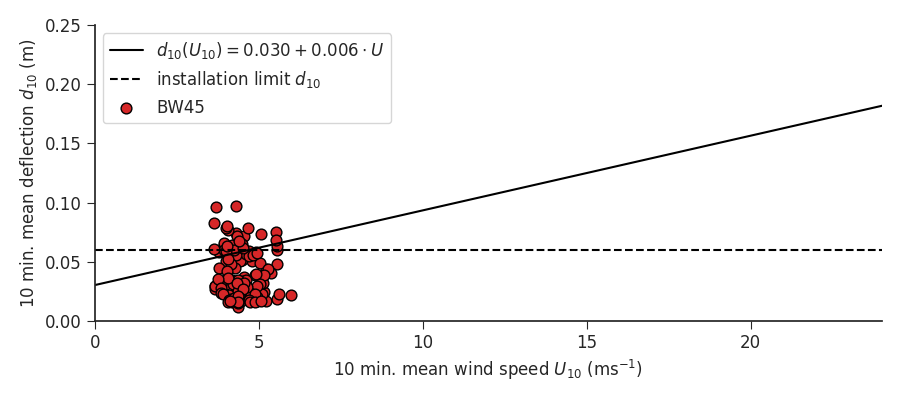

<IPython.core.display.Javascript object>


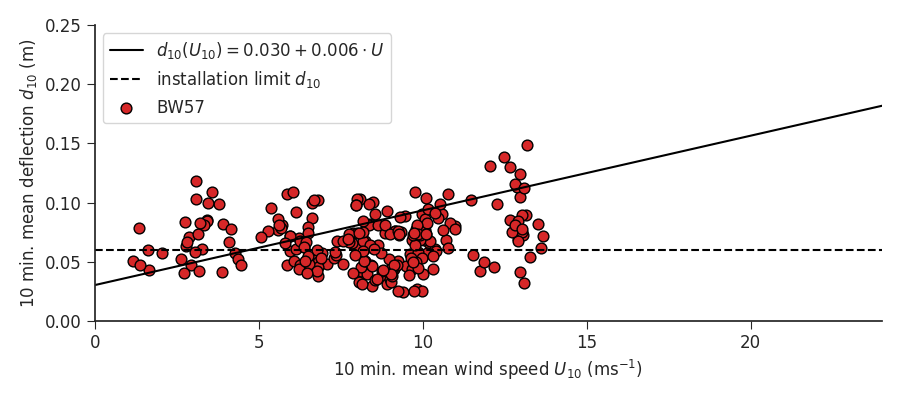

<IPython.core.display.Javascript object>


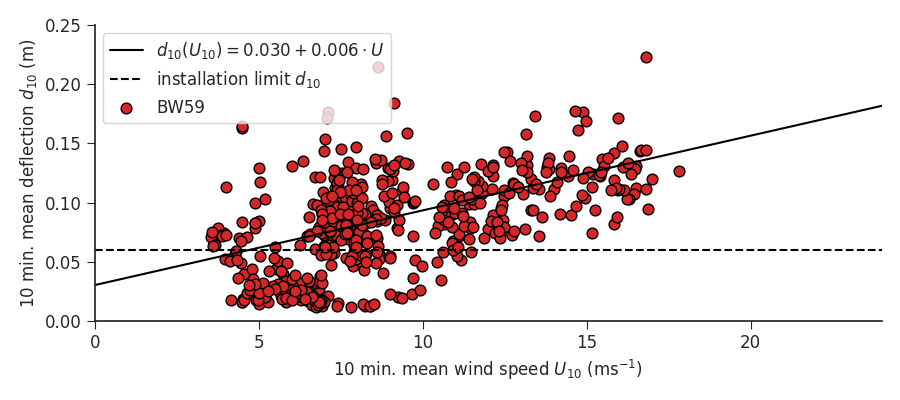

<IPython.core.display.Javascript object>


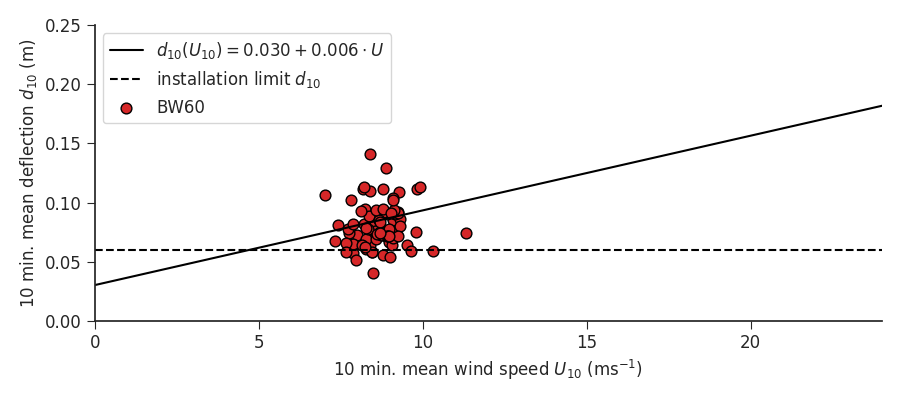

<IPython.core.display.Javascript object>


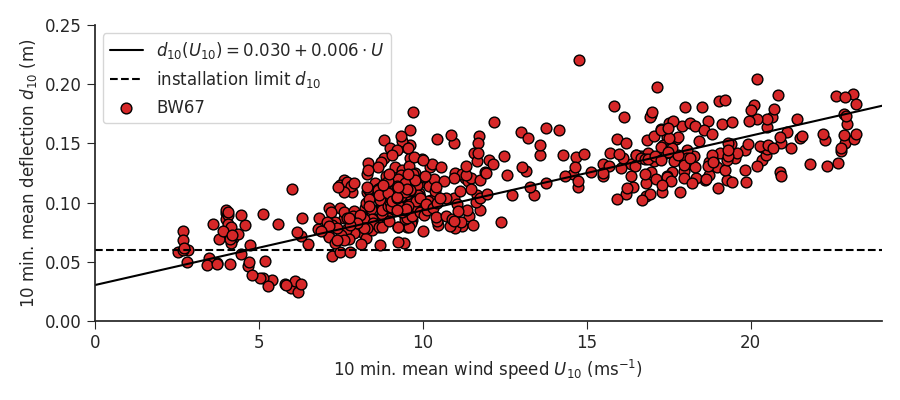

<IPython.core.display.Javascript object>


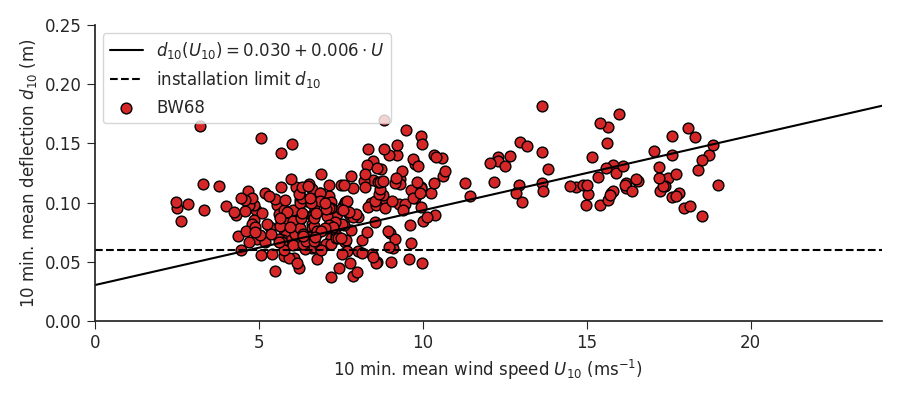

<IPython.core.display.Javascript object>


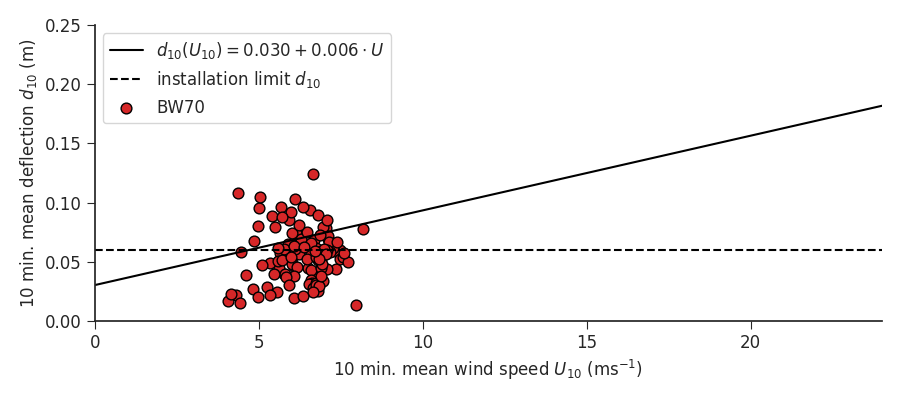

<IPython.core.display.Javascript object>


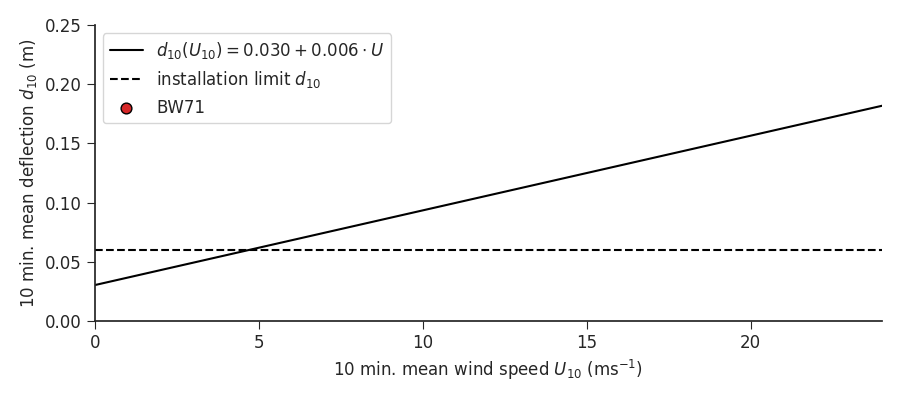

<IPython.core.display.Javascript object>


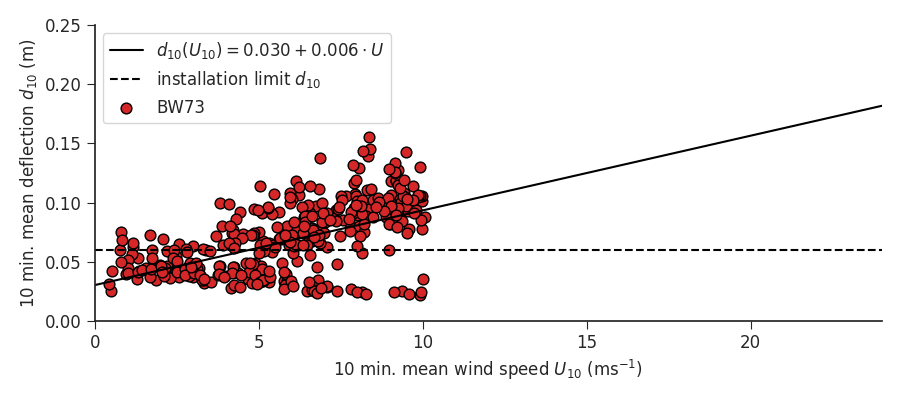

<IPython.core.display.Javascript object>


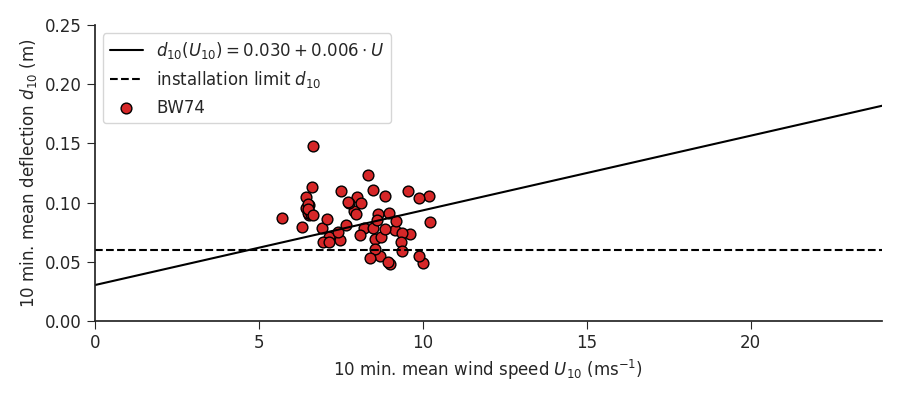

<IPython.core.display.Javascript object>


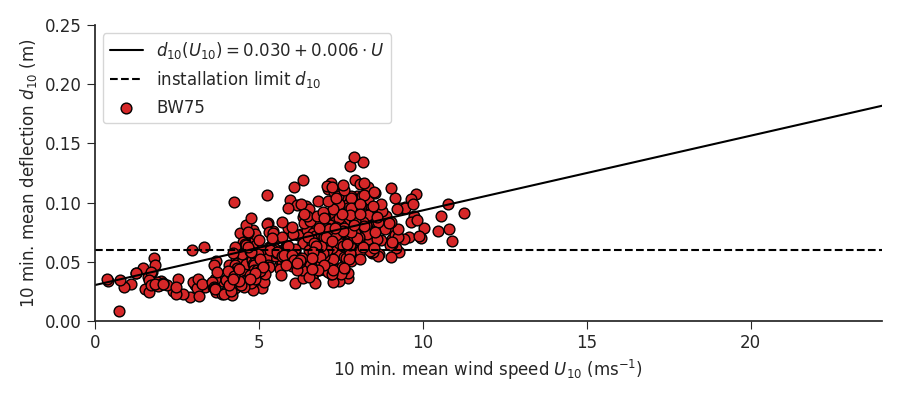

<IPython.core.display.Javascript object>


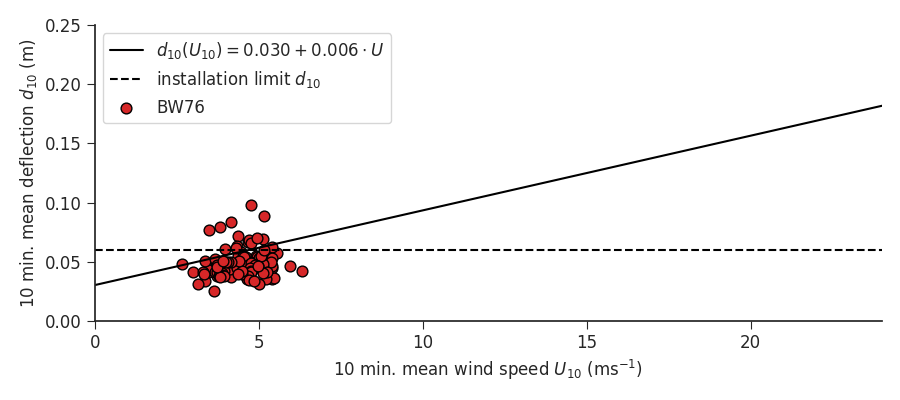

<IPython.core.display.Javascript object>


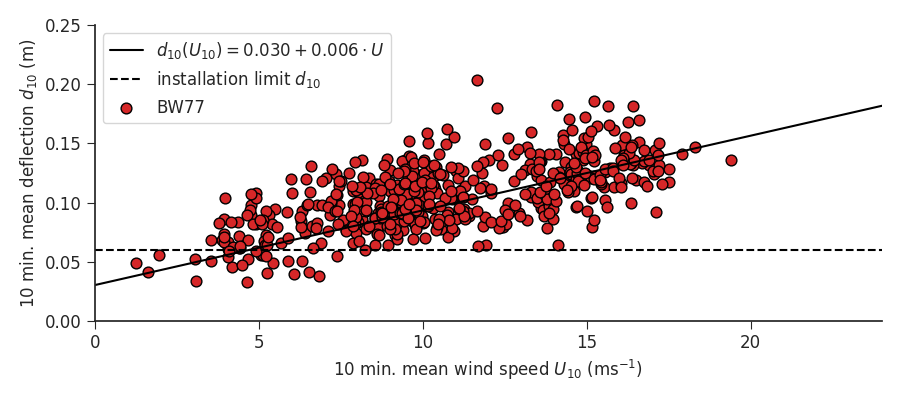

In [60]:
for t in turbines:
    plt.figure(figsize=(9,4))    
    plt.scatter(turbines[t].wind_speed.resample('10min').mean(),
                turbines[t].deflection.resample('10min').mean(),
                color='tab:red',
                edgecolor='k',
                label='{}'.format(t),
                s=60,
               )
    plt.plot([x for x in range(0, 28)],
         [(windCorr.intercept + windCorr.slope*x) for x in range(0, 28)],
         label='$d_{10}(U_{10})$'+'$ = {:1.3f} + {:1.3f} \cdot U$ '.format(windCorr.intercept, windCorr.slope),
         color='k',
        )
    plt.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
    plt.ylabel('10 min. mean deflection $d_{10}$ (m)')
    plt.xlabel('10 min. mean wind speed $U_{10}$ (ms$^{-1}$)')
    plt.legend(frameon=True, fancybox=True, loc='upper left')
    plt.ylim([0, 0.25])
    plt.xlim([0, 24])

    plt.tight_layout()
    plt.savefig('turbines/{}_U10_d10_noTMD.png'.format(t), dpi=150)

In [ ]:
for t in turbines_tmd:
    plt.figure(figsize=(9,4))    
    plt.scatter(turbines_tmd[t].wind_speed.resample('10min').mean(),
                turbines_tmd[t].deflection.resample('10min').mean(),
                color='tab:blue',
                edgecolor='k',
                label='{}'.format(t),
                s=60,
               )
    

    plt.plot([x for x in range(0, 28)],
         [(windCorr_tmd.intercept + windCorr_tmd.slope*x) for x in range(0, 28)],
         label='$d_{10}(U_{10})$'+'$ = {:1.3f} + {:1.3f} \cdot U$'.format(windCorr_tmd.intercept, windCorr_tmd.slope),
         color='k',
        )
    
    plt.axhline(y=0.06, label='installation limit $d_{10}$', color='k', ls='--')
    plt.ylabel('10 min. mean deflection $d_{10}$ (m)')
    plt.xlabel('10 min. mean wind speed $U_{10}$ (ms$^{-1}$)')
    plt.ylim([0, 0.25])
    plt.xlim([0, 24])
    plt.legend(frameon=True, fancybox=True, loc='upper left')

    plt.tight_layout()
    plt.savefig('turbines/{}_U10_d10_TMD.png'.format(t), dpi=150)

In [ ]:
## generate latex include code

includefigure='''\\begin{figure*}
    \centering
    \\begin{subfigure}[b]{\\textwidth}
        \centering
        \includegraphics[width=0.9\\textwidth]{figures/turbines/BWXX_noTMD.png}
        \caption{}
    \end{subfigure} \\\\
    \\begin{subfigure}[b]{\\textwidth}
        \centering
        \includegraphics[width=0.9\\textwidth]{figures/turbines/BWXX_Hs_d10_noTMD.png}
        \caption{}
    \end{subfigure} \\\\
    \\begin{subfigure}[b]{\\textwidth}
        \centering
        \includegraphics[width=0.9\\textwidth]{figures/turbines/BWXX_U10_d10_noTMD.png}
        \caption{}
    \end{subfigure} \\\\
    \caption{BWXX (a) time series (b) 10 min. mean deflection as a function of the significant wave height}
    \label{fig:BWXX}
\end{figure*}
'''

for t in turbines:
    print(includefigure.replace('BWXX', t))

In [ ]:
includefigure='''\\begin{figure*}
    \centering
    \\begin{subfigure}[b]{\\textwidth}
        \centering
        \includegraphics[width=0.9\\textwidth]{figures/turbines/BWXX_TMD.png}
        \caption{}
    \end{subfigure} \\\\
    \\begin{subfigure}[b]{\\textwidth}
        \centering
        \includegraphics[width=0.9\\textwidth]{figures/turbines/BWXX_Hs_d10_TMD.png}
        \caption{}
    \end{subfigure} \\\\
    \\begin{subfigure}[b]{\\textwidth}
        \centering
        \includegraphics[width=0.9\\textwidth]{figures/turbines/BWXX_U10_d10_TMD.png}
        \caption{}
    \end{subfigure} \\\\
    \caption{BWXX (a) time series (b) 10 min. mean deflection as a function of the significant wave height}
    \label{fig:BWXX}
\end{figure*}
'''

for t in turbines_tmd:
    print(includefigure.replace('BWXX', t))